### Develop an ML Linear Regression model to learn High Entropy Alloy Hardness Property

In this tutorial we will learn to create an ML model for harness property prediction for high entropy alloys. We will go through the following steps:

Tutorial 3
1. Polynomial regression
2. Regularization
3. Hyper-parameter optimization



Tutorial 4
1. Normalization
2. Recursive feature elimination

### Importand python library imports

In [581]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import copy

In [582]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [583]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV

### 1. Load train data table

In [584]:
!gdown 12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h

zsh:1: command not found: gdown


In [585]:
data = pd.read_csv('alloy-confp-train-data_v2.csv')
data

Unnamed: 0   ID   HV      C.al      C.co      C.cr      C.cu      C.fe  \
0            10   87  483  0.120000  0.000000  0.310000  0.200000  0.050000   
1           114   29  172  0.000000  0.166667  0.333333  0.166667  0.166667   
2            82   48  295  0.153846  0.307692  0.153846  0.076923  0.153846   
3            28   98  521  0.193548  0.000000  0.161290  0.161290  0.161290   
4            55   89  487  0.238095  0.190476  0.190476  0.000000  0.190476   
..          ...  ...  ...       ...       ...       ...       ...       ...   
115         107  141  655  0.149925  0.283358  0.283358  0.000000  0.283358   
116         113  144  695  0.384615  0.153846  0.153846  0.000000  0.153846   
117          53  111  548  0.225000  0.225000  0.225000  0.000000  0.225000   
118          33   76  469  0.120000  0.000000  0.310000  0.210000  0.050000   
119         111  133  609  0.307692  0.153846  0.153846  0.076923  0.153846   

         C.ni  
0    0.320000  
1    0.166667  
2    0.153846  
3    0.322581  
4    0.190476  
..        ...  
115  0.000000  
116  0.153846  
117  0.100000  
118  0.310000  
119  0.153846  

[120 rows x 9 columns]

#### Notes about the data table

Above we see that data table has 3 types of columns:
1. ID: Serial number of the alloys.
2. HV: This is the experimentally measured hardness values of the alloys. Our target property (y).    
3. C.*: concentration of different elements in the alloys.

#### Separate X and y data

In [586]:
Xcols = data.columns[data.columns.str.contains("C.")]
X = data[Xcols]
X

C.al      C.co      C.cr      C.cu      C.fe      C.ni
0    0.120000  0.000000  0.310000  0.200000  0.050000  0.320000
1    0.000000  0.166667  0.333333  0.166667  0.166667  0.166667
2    0.153846  0.307692  0.153846  0.076923  0.153846  0.153846
3    0.193548  0.000000  0.161290  0.161290  0.161290  0.322581
4    0.238095  0.190476  0.190476  0.000000  0.190476  0.190476
..        ...       ...       ...       ...       ...       ...
115  0.149925  0.283358  0.283358  0.000000  0.283358  0.000000
116  0.384615  0.153846  0.153846  0.000000  0.153846  0.153846
117  0.225000  0.225000  0.225000  0.000000  0.225000  0.100000
118  0.120000  0.000000  0.310000  0.210000  0.050000  0.310000
119  0.307692  0.153846  0.153846  0.076923  0.153846  0.153846

[120 rows x 6 columns]

In [587]:
y = data['HV']
y

0      483
1      172
2      295
3      521
4      487
      ... 
115    655
116    695
117    548
118    469
119    609
Name: HV, Length: 120, dtype: int64

### 2. Visualize data

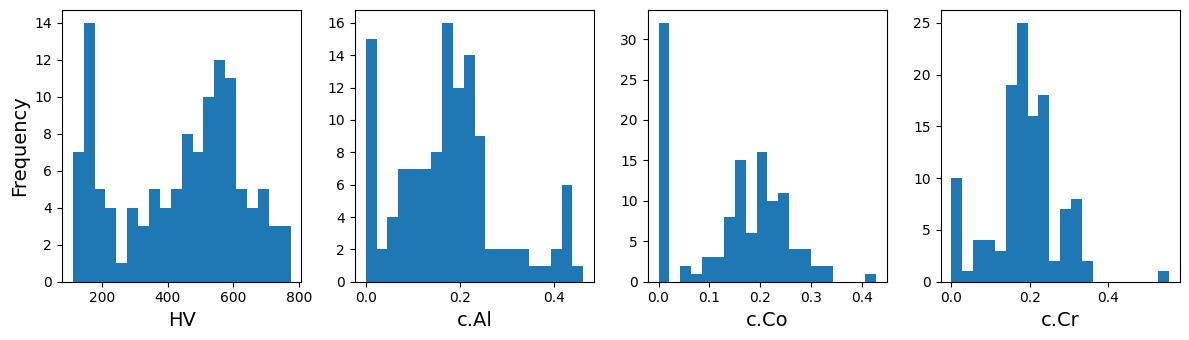

In [588]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,3.5))

ax1.hist(y.values, bins=20)
ax2.hist(X.values[:,0], bins=20, label='c.Al')
ax3.hist(X.values[:,1], bins=20, label='c.Co')
ax4.hist(X.values[:,2], bins=20, label='c.Cr')

ax1.set_xlabel('HV', fontsize=14)
ax2.set_xlabel('c.Al', fontsize=14)
ax3.set_xlabel('c.Co', fontsize=14)
ax4.set_xlabel('c.Cr', fontsize=14)

ax1.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

### Question
Why is it important to visualize data?

### 3. Train an ML model

In [589]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """
    
    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)
    
    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)
        
    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])    
    
    if y_cv_train is not None: 
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)
        
        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)    
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)    
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])    

    plt.tight_layout()
    plt.show()
    
    return None

#### Our own LR code using the equation discuseed in class

In [590]:
X_tras_X_inv = np.linalg.inv(np.dot(X.T,X))
X_tras_y = np.dot(X.T,y)
w_cap_vec = np.dot(X_tras_X_inv,X_tras_y)
y_pred_manual = np.dot(X,w_cap_vec)

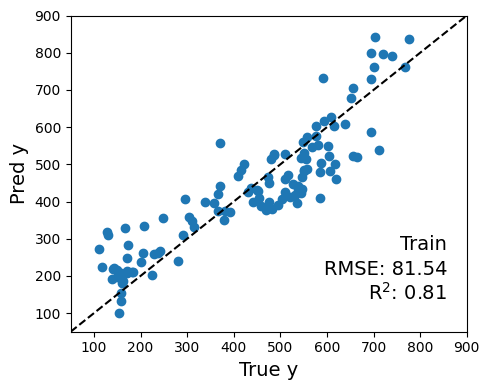

In [591]:
polt_parity(y,y_pred_manual, label="Train")

#### Using sklearn in-built python library

In [592]:
lr = LinearRegression(fit_intercept=False)
model = lr.fit(X,y)
lr_model = copy.deepcopy(model)

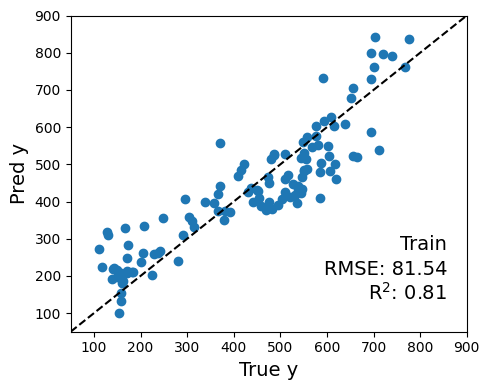

In [593]:
y_pred = model.predict(X)
polt_parity(y,y_pred, label="Train")

#### Comparing sklearn library vs our equation results 

In [594]:
print("Sklearn model: ", lr_model.coef_)
print("Eq. based model: ", w_cap_vec)

Sklearn model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]
Eq. based model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]


#### Error with baseline average model

In [595]:
y_avg_pred = [y.mean()]*len(y)
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y, y_avg_pred)))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_avg_pred))

Root mean squared error: 186.35
Coefficient of determination: 0.00


### Question
2. Why is it important to compare model performance with a baseline model?
3. Is there any issue with the way we have computed the accuracy/ performance of the linear regression model?

### 4. Model assessment, cross-validation

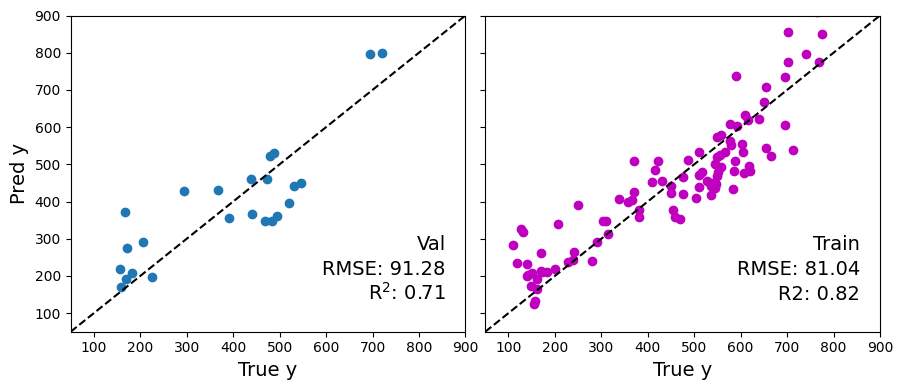

Root mean squared error: 91.28
Coefficient of determination: 0.71


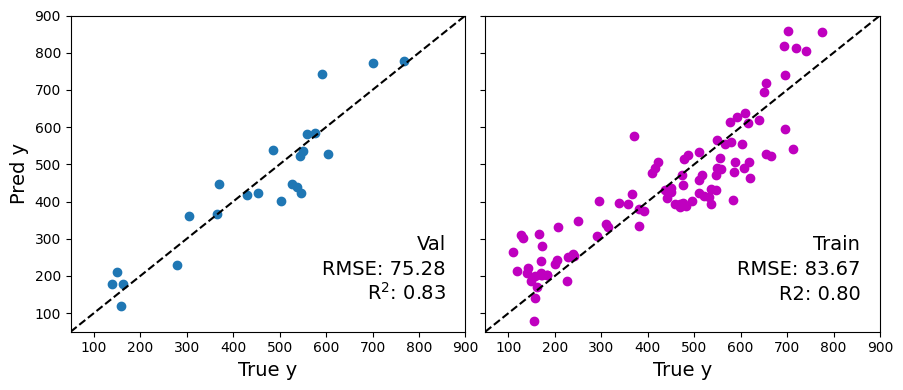

Root mean squared error: 75.28
Coefficient of determination: 0.83


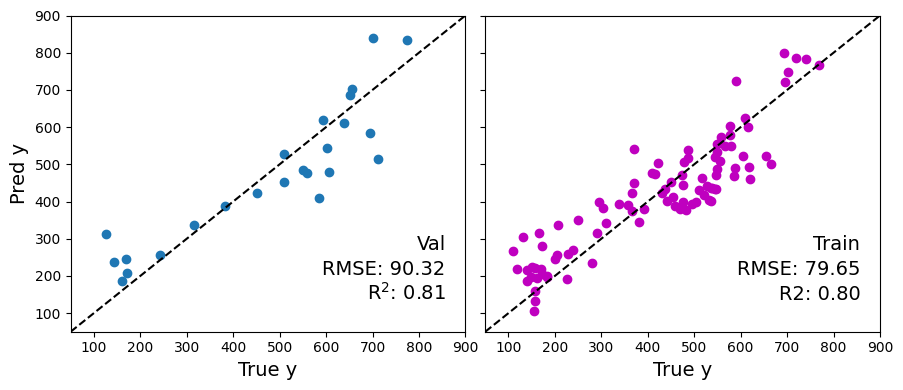

Root mean squared error: 90.32
Coefficient of determination: 0.81


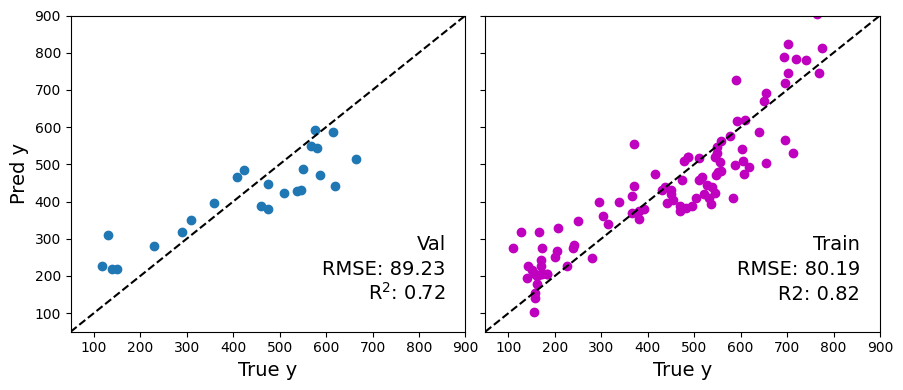

Root mean squared error: 89.23
Coefficient of determination: 0.72


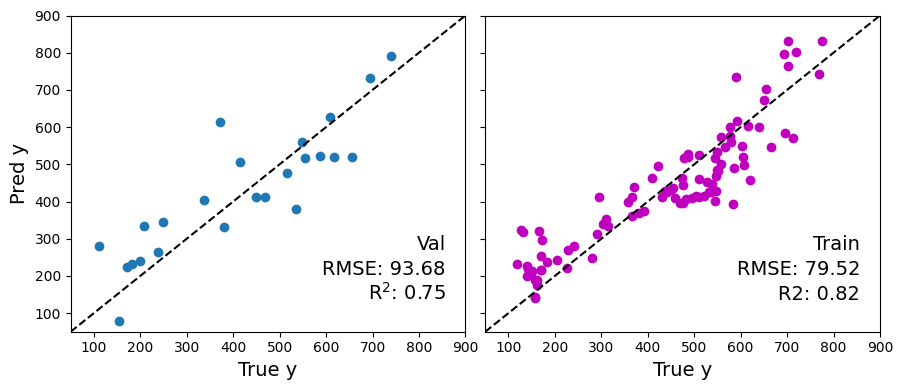

Root mean squared error: 93.68
Coefficient of determination: 0.75


In [596]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [597]:
errors = pd.DataFrame(errors)
errors

kfold  rmse_train  r2_train   rmse_val    r2_val
0      1   81.042167  0.815144  91.279147  0.708392
1      2   83.669628  0.799402  75.276051  0.829048
2      3   79.648091  0.803030  90.317348  0.807092
3      4   80.187879  0.822271  89.228125  0.724304
4      5   79.524513  0.816534  93.677478  0.751586

### Question
1. Why error on training set is consistently lower than that on validation set?
2. Further, the errors on various validation sets are also different. Which is the correct value that best *estimate* the performance of the ML model? 

In [598]:
errors[['rmse_val','r2_val']].mean()

rmse_val    87.955630
r2_val       0.764085
dtype: float64

### Question
1. Is MSE on training data expected to be higher or lower than that on validation/test errors? Discuss.
2. For various values of k-folds, ranging from 2-10, plot average validation RMSE error. Discuss the behavior of the obtained plot.

## Start of Tutorial 3

In this tutorial we would learn 
1. Polynomial regression improves model accuracy
2. Regularization
3. How to determine lambda coefficient for regularization
4. Normalization 
5. Comparing all models

### Building polynomial features

In [599]:
new_data = data.copy()

In [600]:
def make_new_feature(data, cols, powers, new_col_name):
    data[new_col_name] = 1
    for power, col in zip(powers, cols):
        data[new_col_name] = data[new_col_name] * (data[Xcols[col]] ** power)
        
    return data

In [601]:
cols = [0,1]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.1')

In [602]:
new_data

Unnamed: 0   ID   HV      C.al      C.co      C.cr      C.cu      C.fe  \
0            10   87  483  0.120000  0.000000  0.310000  0.200000  0.050000   
1           114   29  172  0.000000  0.166667  0.333333  0.166667  0.166667   
2            82   48  295  0.153846  0.307692  0.153846  0.076923  0.153846   
3            28   98  521  0.193548  0.000000  0.161290  0.161290  0.161290   
4            55   89  487  0.238095  0.190476  0.190476  0.000000  0.190476   
..          ...  ...  ...       ...       ...       ...       ...       ...   
115         107  141  655  0.149925  0.283358  0.283358  0.000000  0.283358   
116         113  144  695  0.384615  0.153846  0.153846  0.000000  0.153846   
117          53  111  548  0.225000  0.225000  0.225000  0.000000  0.225000   
118          33   76  469  0.120000  0.000000  0.310000  0.210000  0.050000   
119         111  133  609  0.307692  0.153846  0.153846  0.076923  0.153846   

         C.ni       n.1  
0    0.320000  0.000000  
1    0.166667  0.000000  
2    0.153846  0.047337  
3    0.322581  0.000000  
4    0.190476  0.045351  
..        ...       ...  
115  0.000000  0.042483  
116  0.153846  0.059172  
117  0.100000  0.050625  
118  0.310000  0.000000  
119  0.153846  0.047337  

[120 rows x 10 columns]

In [603]:
cols = [1,3]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.2')

cols = [2,4]
powers = [1,2]
new_data = make_new_feature(new_data, cols, powers, 'n.3')

cols = [3,4,5]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.4')

cols = [4,5]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.5')

cols = [1,2,4]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.6')

cols = [2,3,4]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.7')

cols = [4,5,1]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.8')

cols = [1,2,3]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.9')

cols = [1,2]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.10')

cols = [0,4]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.11')


In [604]:
new_data

Unnamed: 0   ID   HV      C.al      C.co      C.cr      C.cu      C.fe  \
0            10   87  483  0.120000  0.000000  0.310000  0.200000  0.050000   
1           114   29  172  0.000000  0.166667  0.333333  0.166667  0.166667   
2            82   48  295  0.153846  0.307692  0.153846  0.076923  0.153846   
3            28   98  521  0.193548  0.000000  0.161290  0.161290  0.161290   
4            55   89  487  0.238095  0.190476  0.190476  0.000000  0.190476   
..          ...  ...  ...       ...       ...       ...       ...       ...   
115         107  141  655  0.149925  0.283358  0.283358  0.000000  0.283358   
116         113  144  695  0.384615  0.153846  0.153846  0.000000  0.153846   
117          53  111  548  0.225000  0.225000  0.225000  0.000000  0.225000   
118          33   76  469  0.120000  0.000000  0.310000  0.210000  0.050000   
119         111  133  609  0.307692  0.153846  0.153846  0.076923  0.153846   

         C.ni       n.1       n.2       n.3       n.4       n.5       n.6  \
0    0.320000  0.000000  0.000000  0.000775  0.003200  0.016000  0.000000   
1    0.166667  0.000000  0.027778  0.009259  0.004630  0.027778  0.009259   
2    0.153846  0.047337  0.023669  0.003641  0.001821  0.023669  0.007283   
3    0.322581  0.000000  0.000000  0.004196  0.008392  0.052029  0.000000   
4    0.190476  0.045351  0.000000  0.006911  0.000000  0.036281  0.006911   
..        ...       ...       ...       ...       ...       ...       ...   
115  0.000000  0.042483  0.000000  0.022751  0.000000  0.000000  0.022751   
116  0.153846  0.059172  0.000000  0.003641  0.000000  0.023669  0.003641   
117  0.100000  0.050625  0.000000  0.011391  0.000000  0.022500  0.011391   
118  0.310000  0.000000  0.000000  0.000775  0.003255  0.015500  0.000000   
119  0.153846  0.047337  0.011834  0.003641  0.001821  0.023669  0.003641   

          n.7       n.8       n.9      n.10      n.11  
0    0.003100  0.000000  0.000000  0.000000  0.006000  
1    0.009259  0.004630  0.009259  0.055556  0.000000  
2    0.001821  0.007283  0.003641  0.047337  0.023669  
3    0.004196  0.000000  0.000000  0.000000  0.031217  
4    0.000000  0.006911  0.000000  0.036281  0.045351  
..        ...       ...       ...       ...       ...  
115  0.000000  0.000000  0.000000  0.080292  0.042483  
116  0.000000  0.003641  0.000000  0.023669  0.059172  
117  0.000000  0.005063  0.000000  0.050625  0.050625  
118  0.003255  0.000000  0.000000  0.000000  0.006000  
119  0.001821  0.003641  0.001821  0.023669  0.047337  

[120 rows x 20 columns]

In [605]:
Xcols = new_data.columns[new_data.columns.str.contains("C.") | new_data.columns.str.contains("n.")]
X = new_data[Xcols]
X

Unnamed: 0      C.al      C.co      C.cr      C.cu      C.fe      C.ni  \
0            10  0.120000  0.000000  0.310000  0.200000  0.050000  0.320000   
1           114  0.000000  0.166667  0.333333  0.166667  0.166667  0.166667   
2            82  0.153846  0.307692  0.153846  0.076923  0.153846  0.153846   
3            28  0.193548  0.000000  0.161290  0.161290  0.161290  0.322581   
4            55  0.238095  0.190476  0.190476  0.000000  0.190476  0.190476   
..          ...       ...       ...       ...       ...       ...       ...   
115         107  0.149925  0.283358  0.283358  0.000000  0.283358  0.000000   
116         113  0.384615  0.153846  0.153846  0.000000  0.153846  0.153846   
117          53  0.225000  0.225000  0.225000  0.000000  0.225000  0.100000   
118          33  0.120000  0.000000  0.310000  0.210000  0.050000  0.310000   
119         111  0.307692  0.153846  0.153846  0.076923  0.153846  0.153846   

          n.1       n.2       n.3       n.4       n.5       n.6       n.7  \
0    0.000000  0.000000  0.000775  0.003200  0.016000  0.000000  0.003100   
1    0.000000  0.027778  0.009259  0.004630  0.027778  0.009259  0.009259   
2    0.047337  0.023669  0.003641  0.001821  0.023669  0.007283  0.001821   
3    0.000000  0.000000  0.004196  0.008392  0.052029  0.000000  0.004196   
4    0.045351  0.000000  0.006911  0.000000  0.036281  0.006911  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
115  0.042483  0.000000  0.022751  0.000000  0.000000  0.022751  0.000000   
116  0.059172  0.000000  0.003641  0.000000  0.023669  0.003641  0.000000   
117  0.050625  0.000000  0.011391  0.000000  0.022500  0.011391  0.000000   
118  0.000000  0.000000  0.000775  0.003255  0.015500  0.000000  0.003255   
119  0.047337  0.011834  0.003641  0.001821  0.023669  0.003641  0.001821   

          n.8       n.9      n.10      n.11  
0    0.000000  0.000000  0.000000  0.006000  
1    0.004630  0.009259  0.055556  0.000000  
2    0.007283  0.003641  0.047337  0.023669  
3    0.000000  0.000000  0.000000  0.031217  
4    0.006911  0.000000  0.036281  0.045351  
..        ...       ...       ...       ...  
115  0.000000  0.000000  0.080292  0.042483  
116  0.003641  0.000000  0.023669  0.059172  
117  0.005063  0.000000  0.050625  0.050625  
118  0.000000  0.000000  0.000000  0.006000  
119  0.003641  0.001821  0.023669  0.047337  

[120 rows x 18 columns]

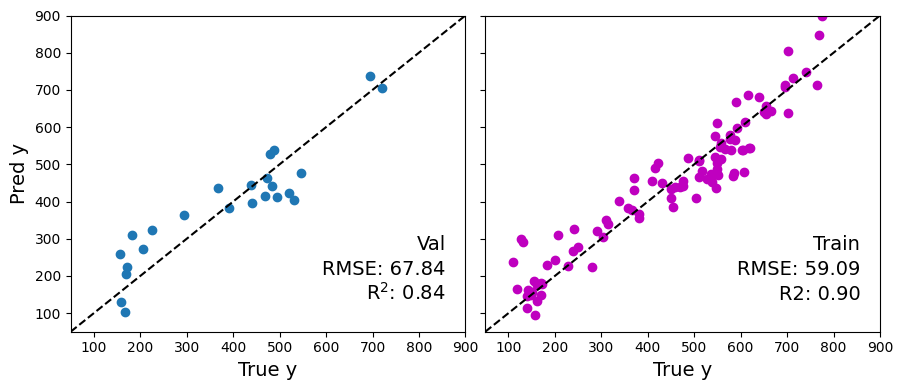

Root mean squared error: 67.84
Coefficient of determination: 0.84


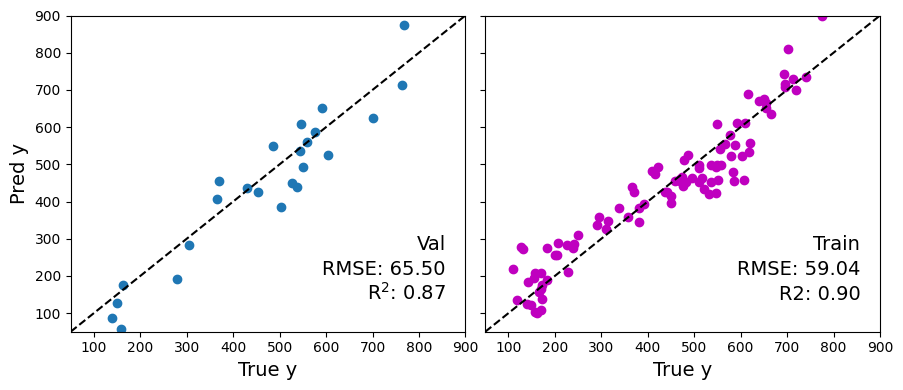

Root mean squared error: 65.50
Coefficient of determination: 0.87


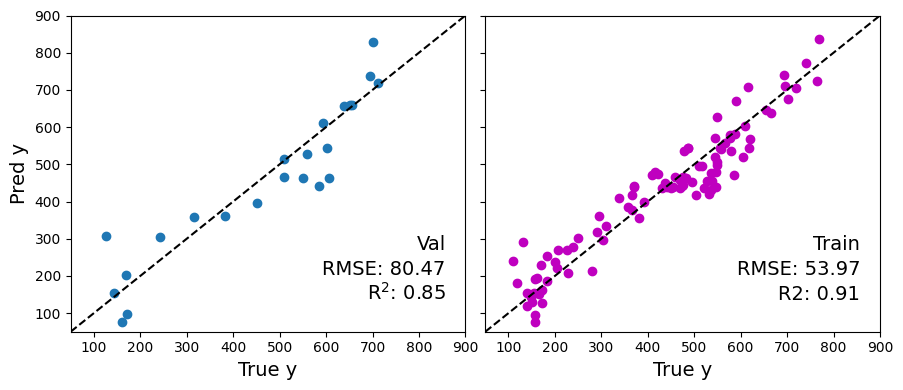

Root mean squared error: 80.47
Coefficient of determination: 0.85


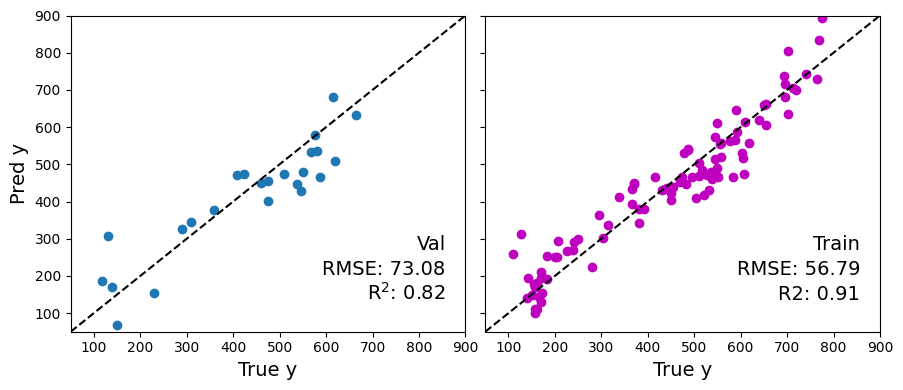

Root mean squared error: 73.08
Coefficient of determination: 0.82


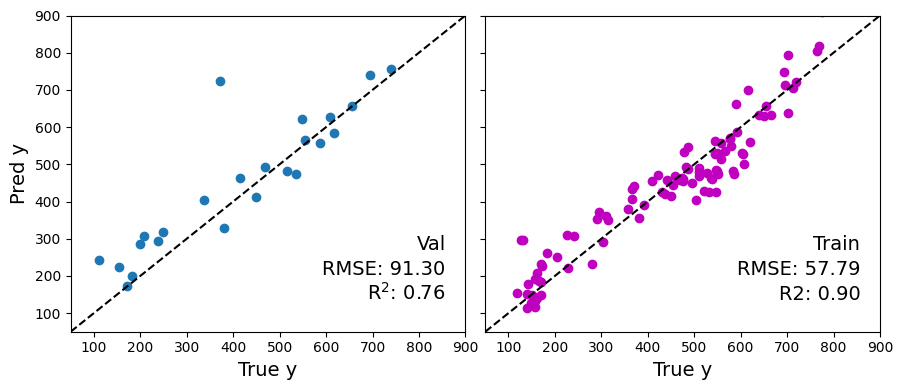

Root mean squared error: 91.30
Coefficient of determination: 0.76


In [606]:
kf = KFold(n_splits=5)

errors_pr = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors_pr.append(error)
errors_pr = pd.DataFrame(errors_pr)    

In [607]:
errors_pr[['rmse_val','r2_val']].mean()

rmse_val    75.637596
r2_val       0.827093
dtype: float64

In [608]:
errors[['rmse_val','r2_val']].mean()

rmse_val    87.955630
r2_val       0.764085
dtype: float64

### Question
1. Why polynomial regression model has better accuracy than that of linear regression model?

### Regularization

In [609]:
pr_l2 = Ridge(alpha=1)

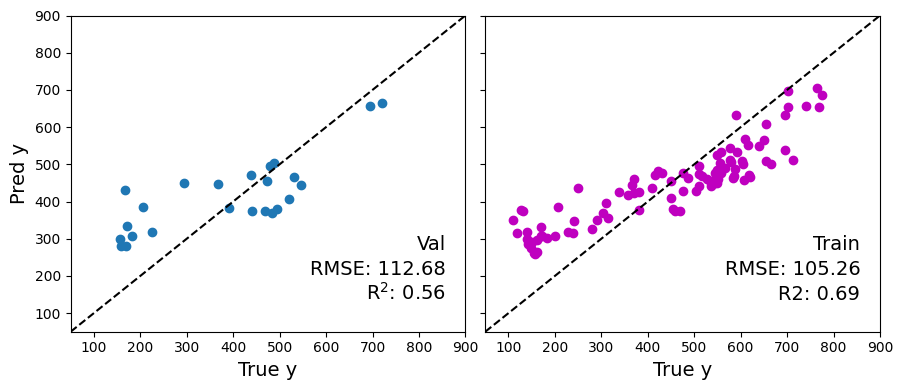

Mean squared error: 112.68
Coefficient of determination: 0.56


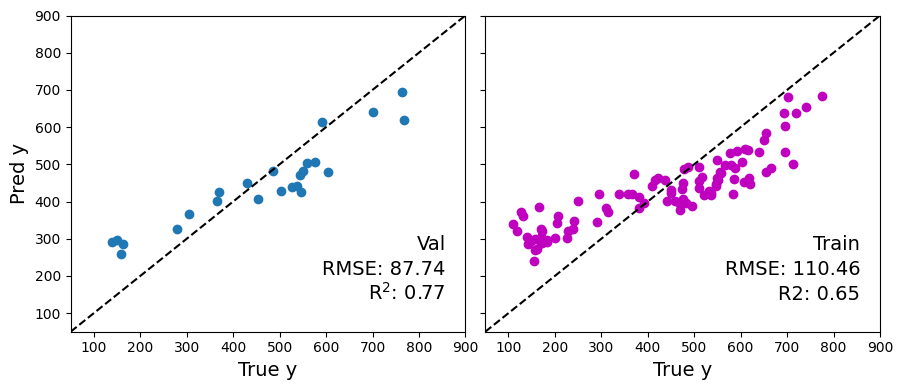

Mean squared error: 87.74
Coefficient of determination: 0.77


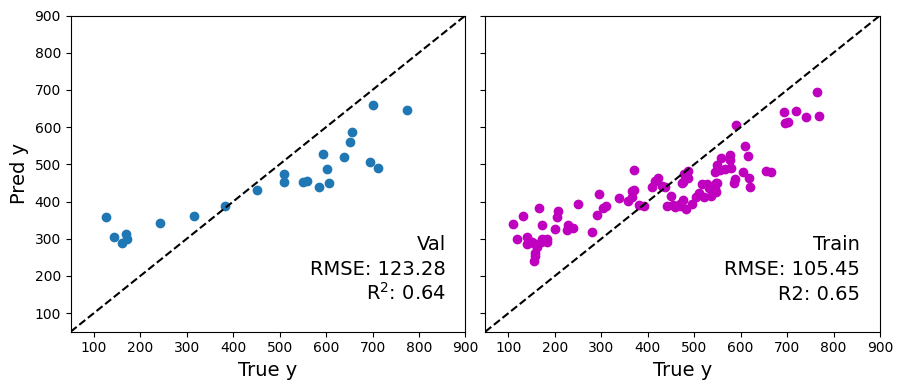

Mean squared error: 123.28
Coefficient of determination: 0.64


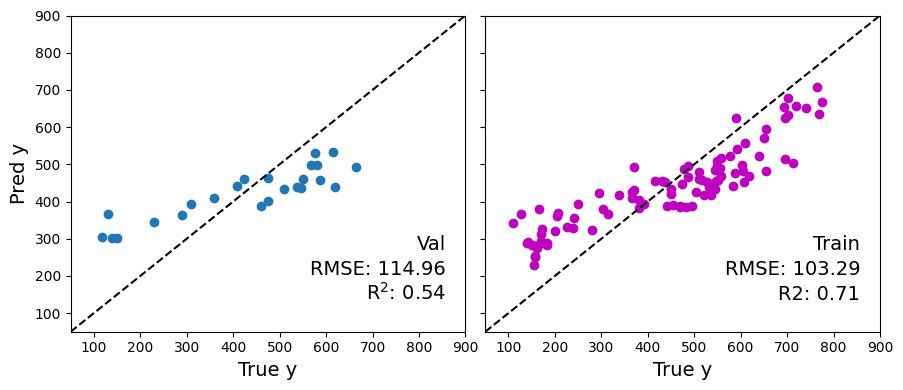

Mean squared error: 114.96
Coefficient of determination: 0.54


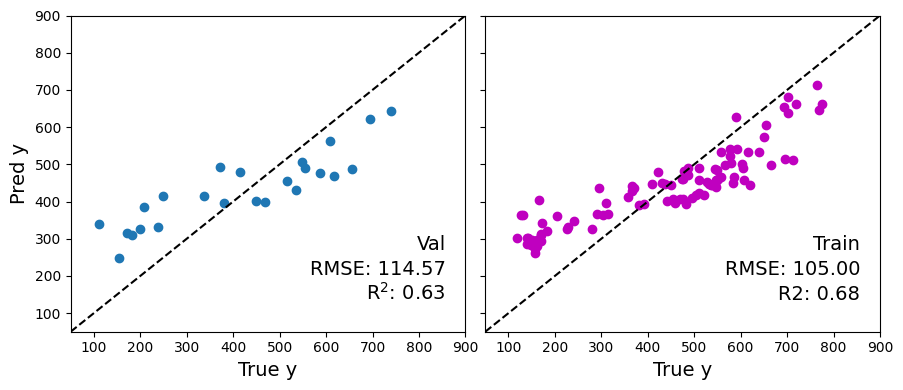

Mean squared error: 114.57
Coefficient of determination: 0.63


In [610]:
errors_pr_l2 = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = pr_l2.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_pr_l2.append(error)
errors_pr_l2 = pd.DataFrame(errors_pr_l2)

### Question
2. Regularization seems to decrease model accuracy. Can you spot someway of improving performance of the regularized model? 

### Regularization with coefficient optimization

In [611]:
c_values = [0.0001, 0.0005, 0.00065, 0.0008, 0.001, 0.0012, 0.0014, 0.002, 0.01, 0.05, 0.1, 1, 2]
hyper_params = {'alpha':c_values}

In [612]:
lr_ridge = Ridge()
clf = GridSearchCV(lr_ridge, hyper_params, cv=5, scoring='neg_mean_squared_error')

In [613]:
_ = clf.fit(X,y)

rmse_list = np.sqrt(clf.cv_results_['mean_test_score']*-1)
rmse_list

array([ 73.43000163,  74.62050356,  74.8738543 ,  75.07067647,
        75.28449249,  75.46763914,  75.63382268,  76.08475176,
        80.04826406,  84.42829479,  85.69296984, 111.29980927,
       131.63460328])

Text(0, 0.5, 'RMSE')

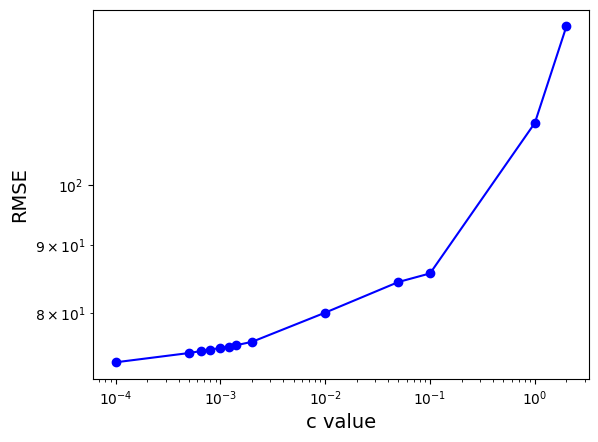

In [614]:
plt.plot(c_values, rmse_list, '-bo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('c value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

In [615]:
min_idx = np.argmin(rmse_list)

c_values[min_idx], rmse_list[min_idx]

(0.0001, 73.43000162954364)

In [616]:
c_opt = c_values[min_idx]

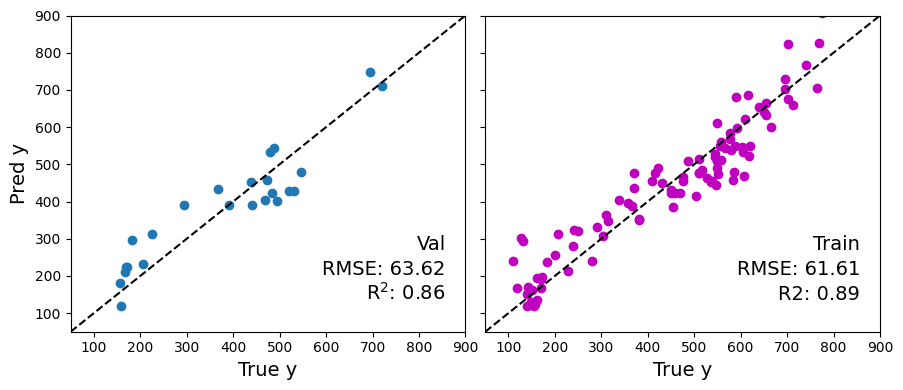

Root Mean squared error: 63.62
Coefficient of determination: 0.86


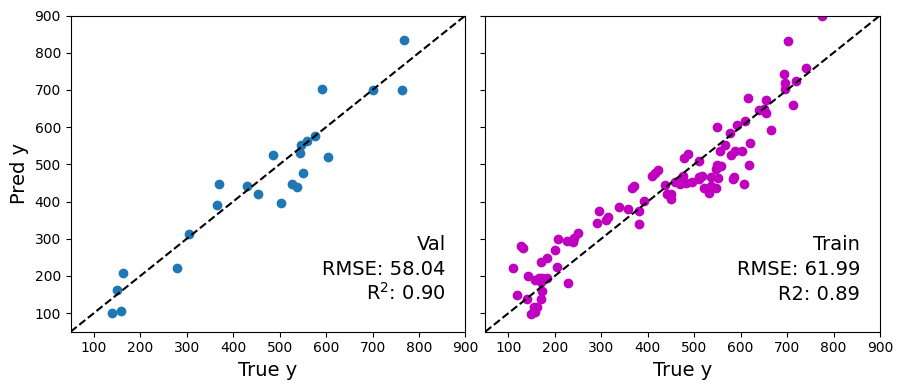

Root Mean squared error: 58.04
Coefficient of determination: 0.90


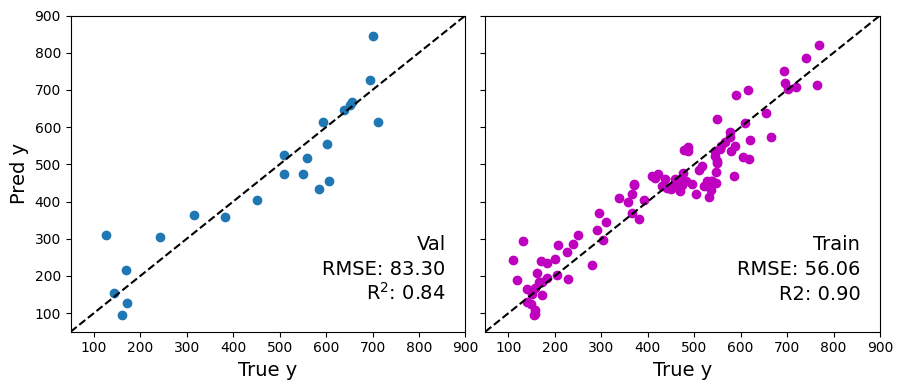

Root Mean squared error: 83.30
Coefficient of determination: 0.84


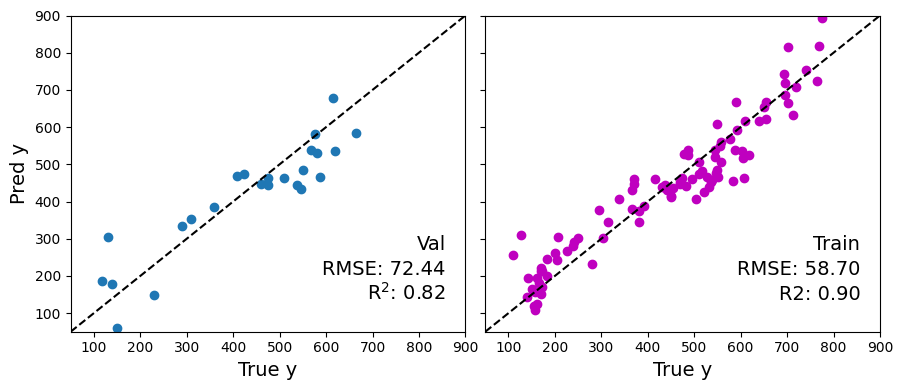

Root Mean squared error: 72.44
Coefficient of determination: 0.82


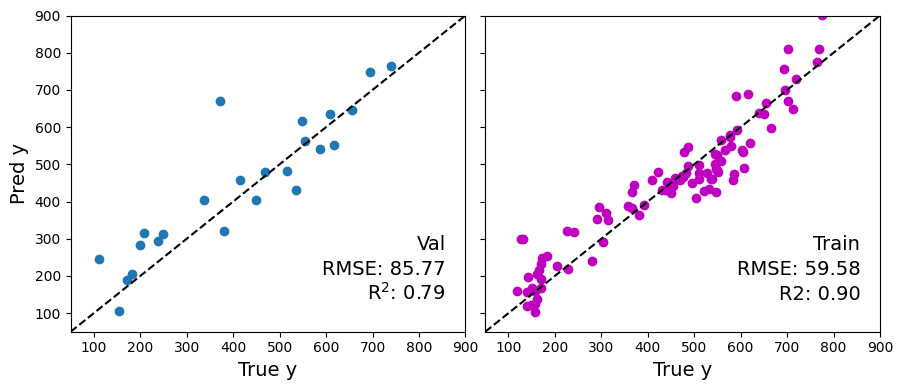

Root Mean squared error: 85.77
Coefficient of determination: 0.79


In [617]:
pr_ridge_c_opt = Ridge(alpha=c_opt)

errors_l2_c_opt = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = pr_ridge_c_opt.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_l2_c_opt.append(error)
errors_l2_c_opt = pd.DataFrame(errors_l2_c_opt)

In [618]:
errors_l2_c_opt[['rmse_val','r2_val']].mean()

rmse_val    72.634987
r2_val       0.840528
dtype: float64

### Question
3. Try making new polynomial type features to improve polynomial regression model accuracy. Explain why addition of new features could improve model performance. 

# Tutorial 4 starts here

### Normalization 

In [619]:
scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(-1, 1))

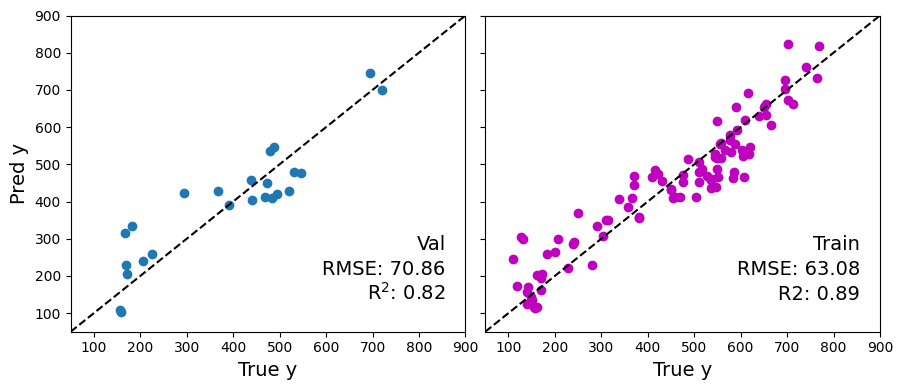

Root Mean squared error: 70.86
Coefficient of determination: 0.82


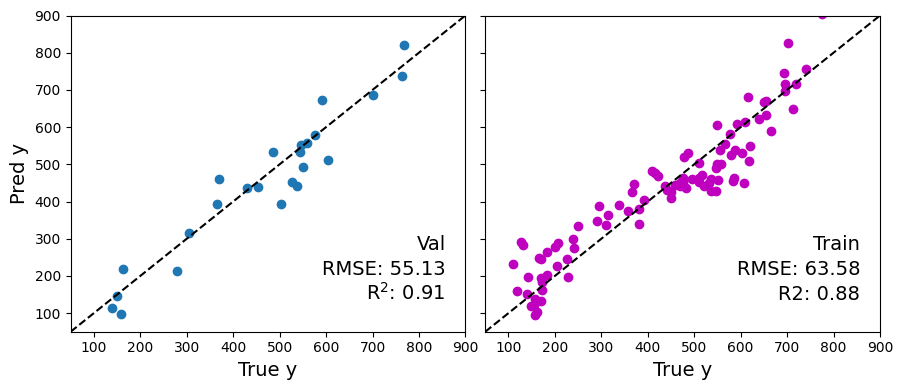

Root Mean squared error: 55.13
Coefficient of determination: 0.91


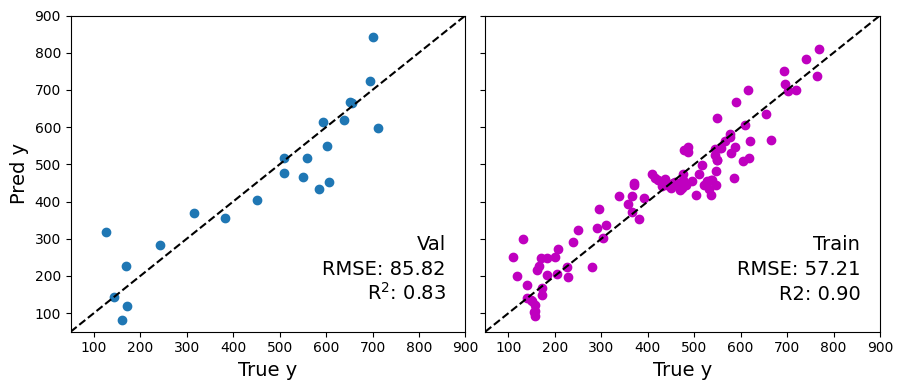

Root Mean squared error: 85.82
Coefficient of determination: 0.83


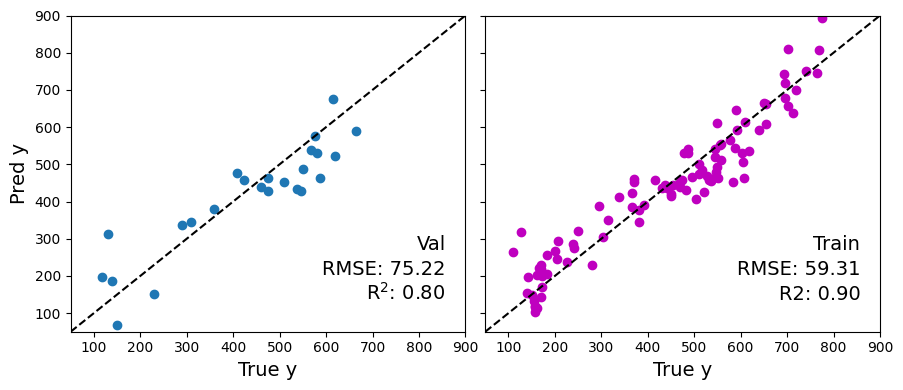

Root Mean squared error: 75.22
Coefficient of determination: 0.80


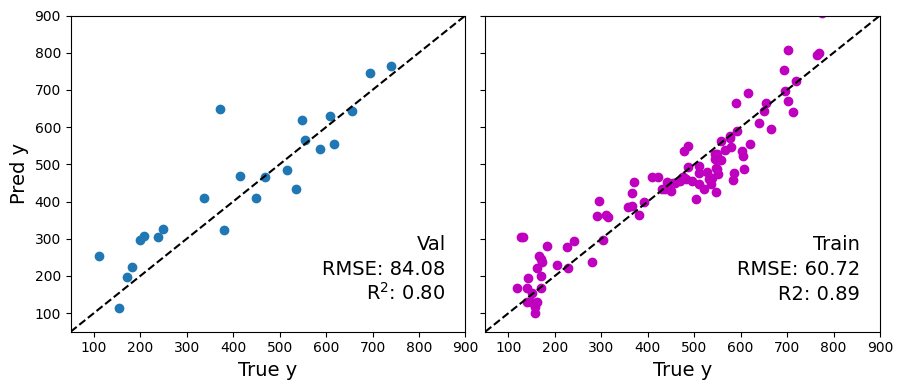

Root Mean squared error: 84.08
Coefficient of determination: 0.80


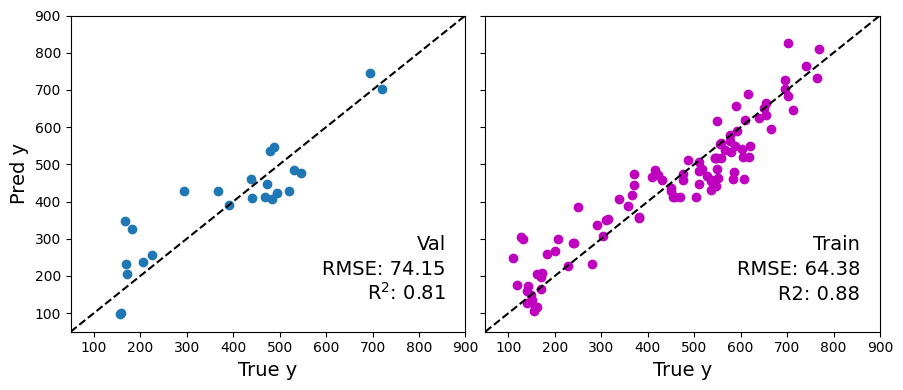

Root Mean squared error: 74.15
Coefficient of determination: 0.81


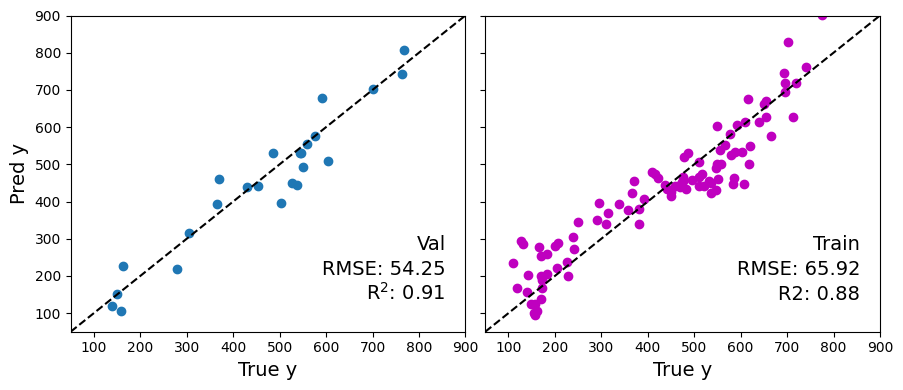

Root Mean squared error: 54.25
Coefficient of determination: 0.91


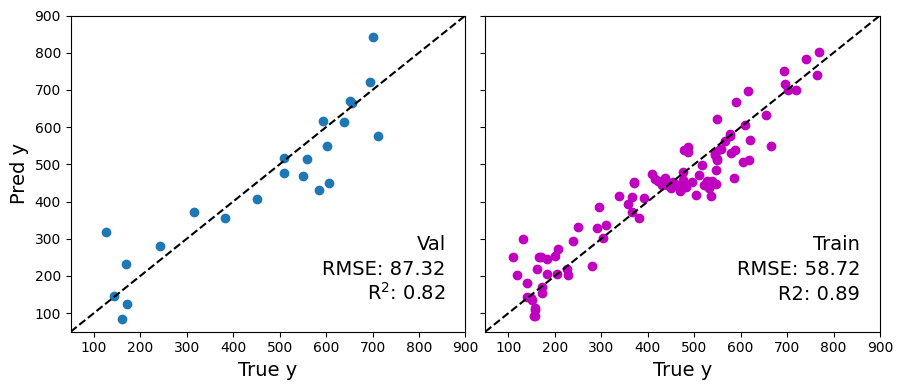

Root Mean squared error: 87.32
Coefficient of determination: 0.82


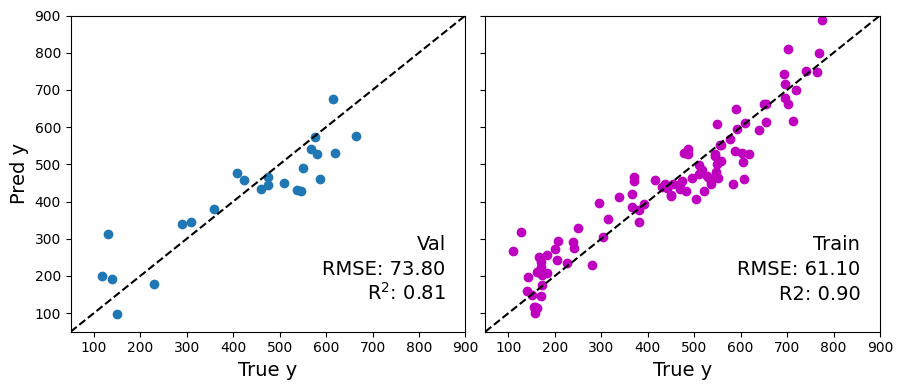

Root Mean squared error: 73.80
Coefficient of determination: 0.81


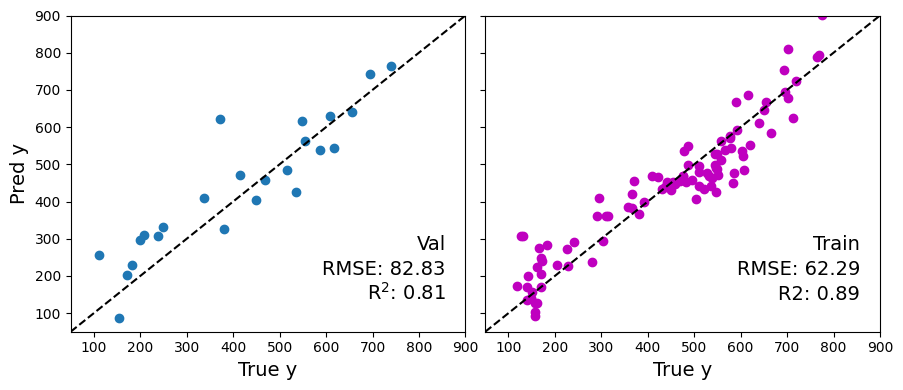

Root Mean squared error: 82.83
Coefficient of determination: 0.81


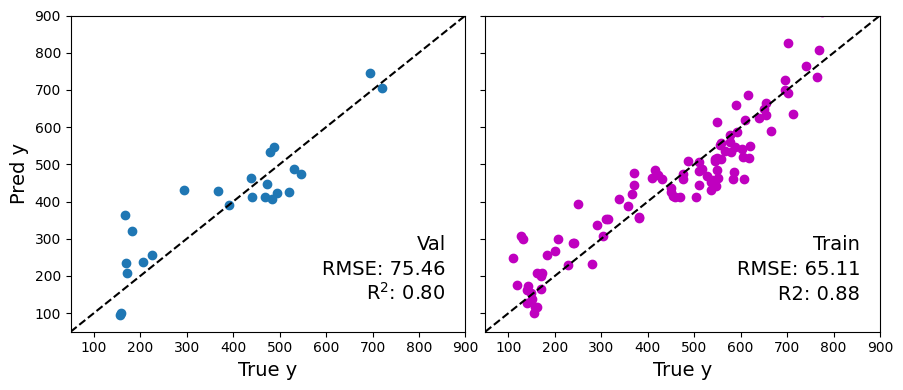

Root Mean squared error: 75.46
Coefficient of determination: 0.80


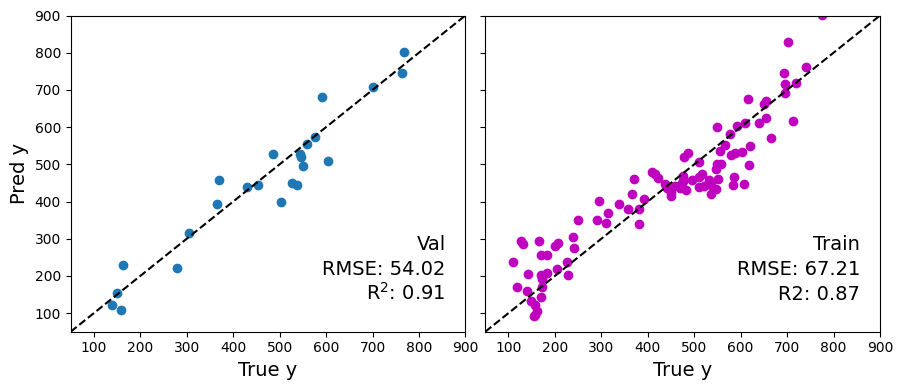

Root Mean squared error: 54.02
Coefficient of determination: 0.91


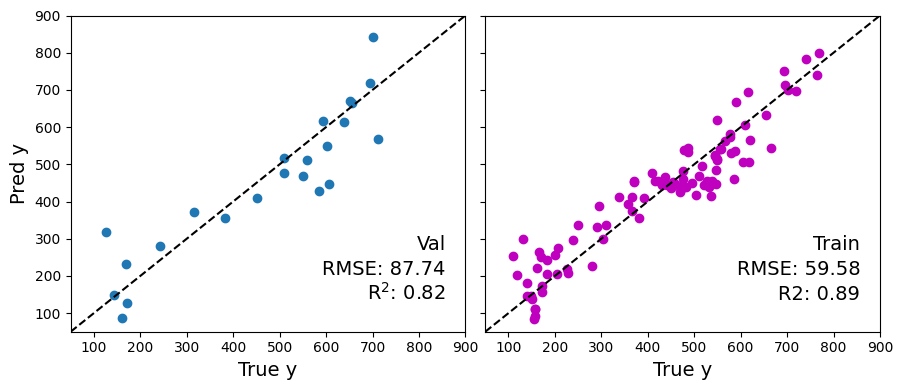

Root Mean squared error: 87.74
Coefficient of determination: 0.82


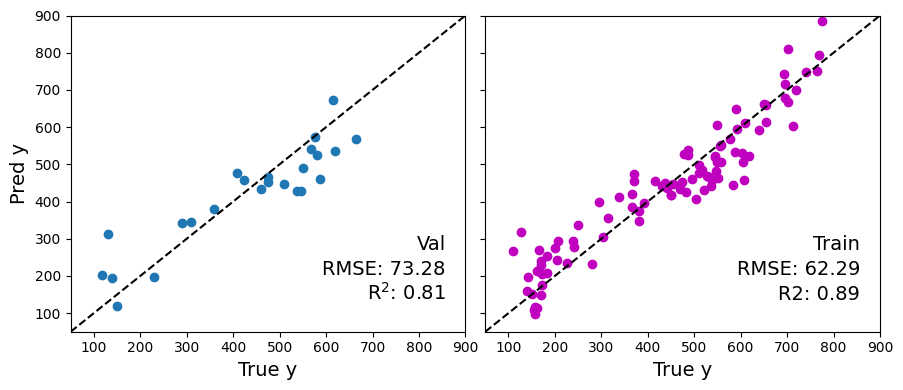

Root Mean squared error: 73.28
Coefficient of determination: 0.81


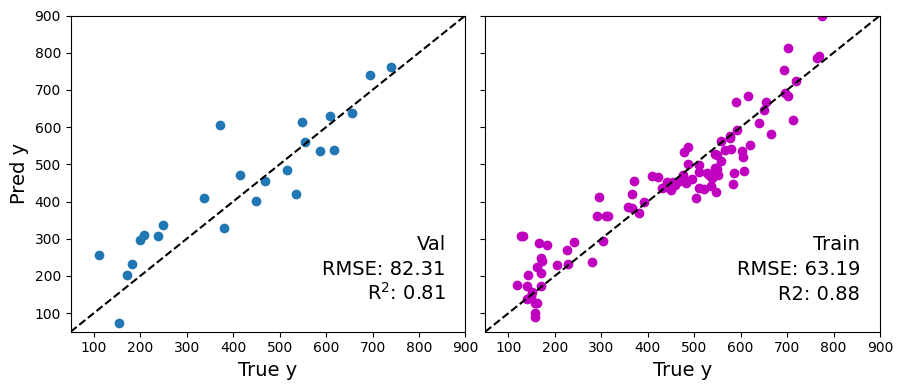

Root Mean squared error: 82.31
Coefficient of determination: 0.81


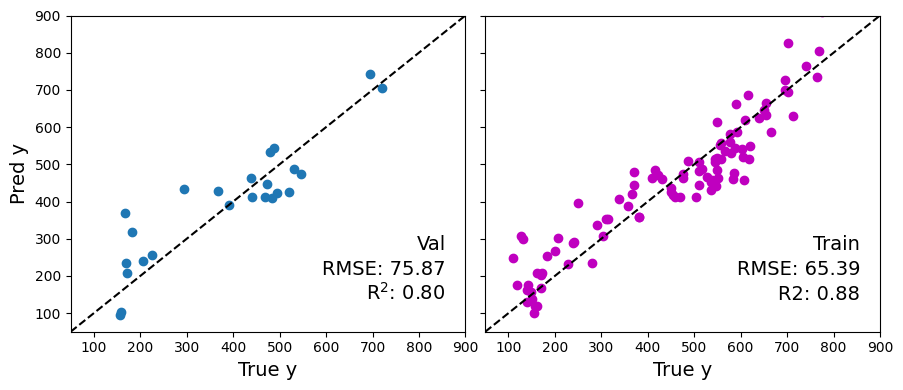

Root Mean squared error: 75.87
Coefficient of determination: 0.80


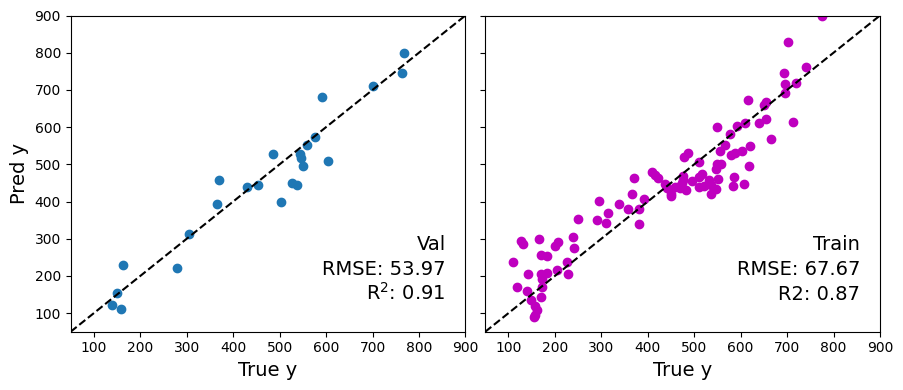

Root Mean squared error: 53.97
Coefficient of determination: 0.91


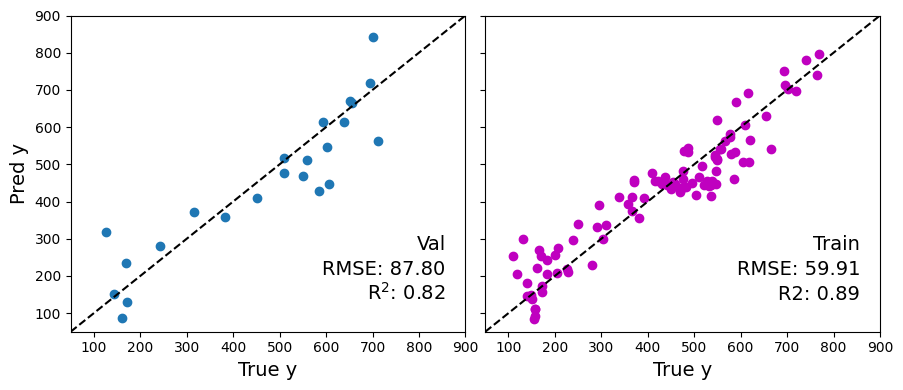

Root Mean squared error: 87.80
Coefficient of determination: 0.82


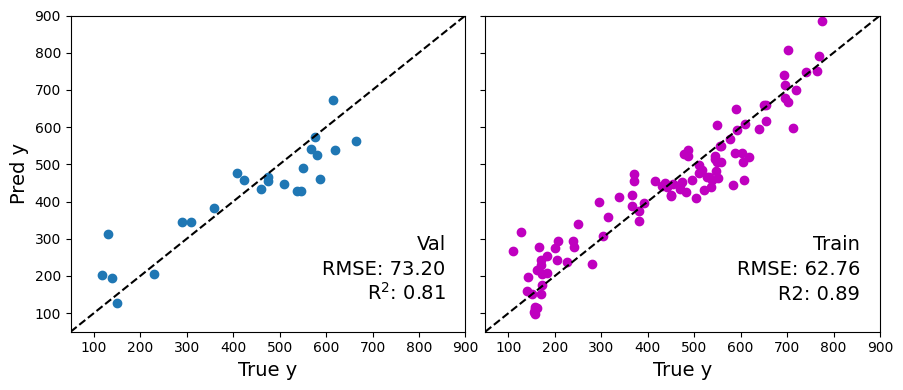

Root Mean squared error: 73.20
Coefficient of determination: 0.81


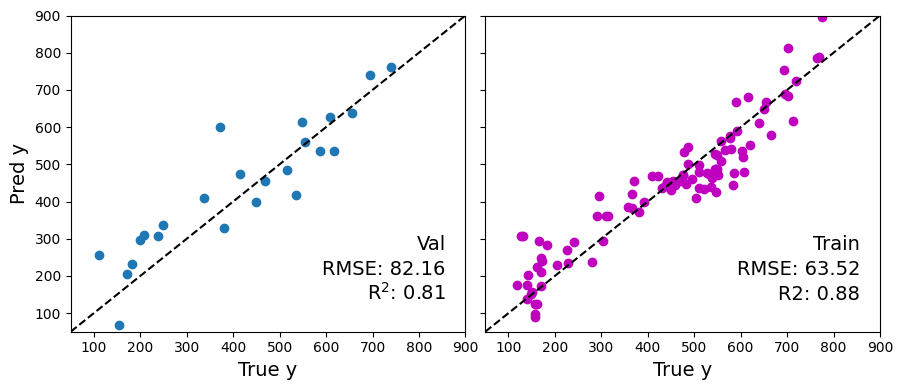

Root Mean squared error: 82.16
Coefficient of determination: 0.81


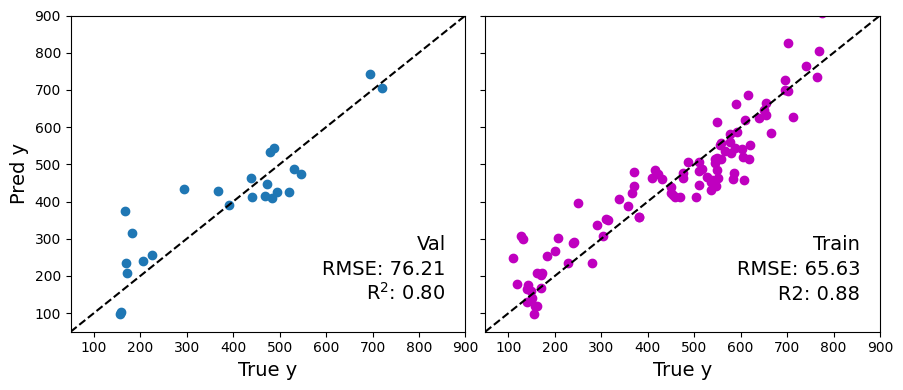

Root Mean squared error: 76.21
Coefficient of determination: 0.80


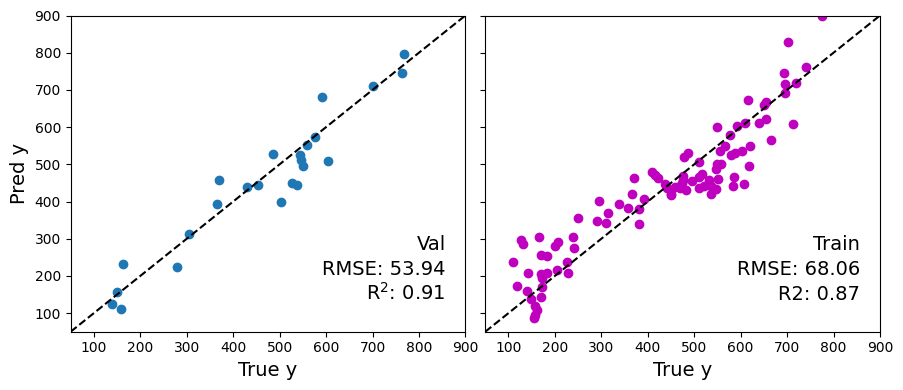

Root Mean squared error: 53.94
Coefficient of determination: 0.91


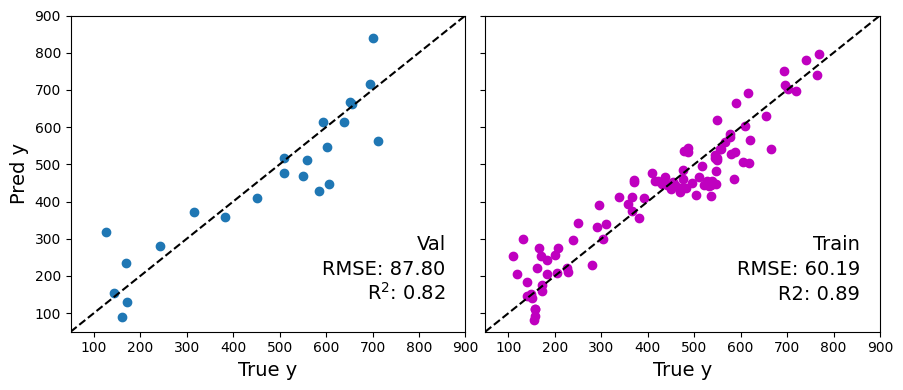

Root Mean squared error: 87.80
Coefficient of determination: 0.82


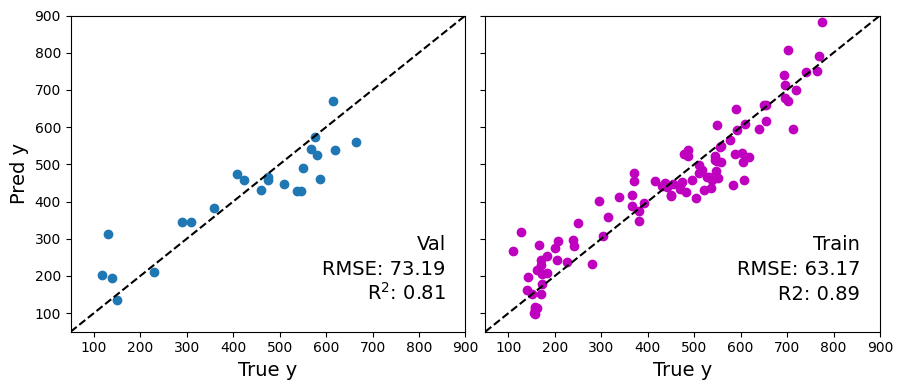

Root Mean squared error: 73.19
Coefficient of determination: 0.81


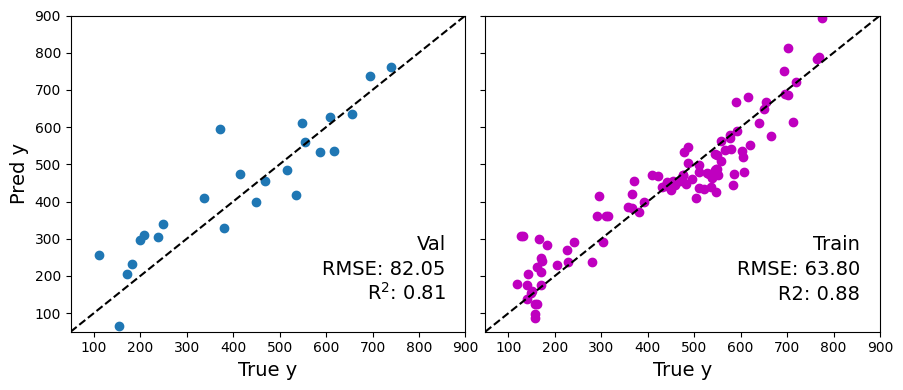

Root Mean squared error: 82.05
Coefficient of determination: 0.81


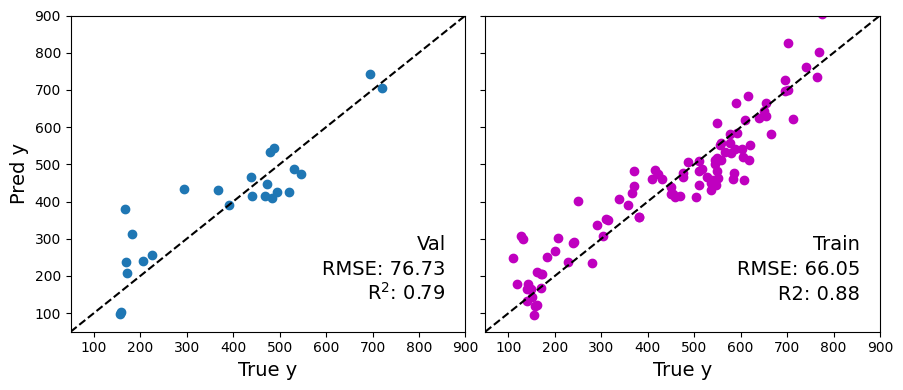

Root Mean squared error: 76.73
Coefficient of determination: 0.79


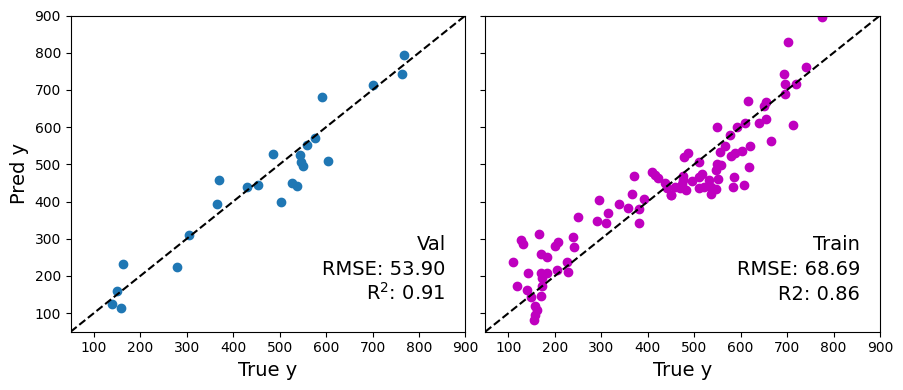

Root Mean squared error: 53.90
Coefficient of determination: 0.91


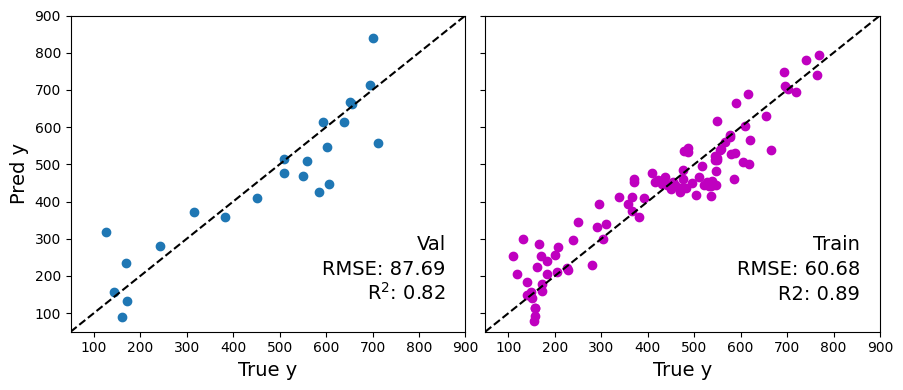

Root Mean squared error: 87.69
Coefficient of determination: 0.82


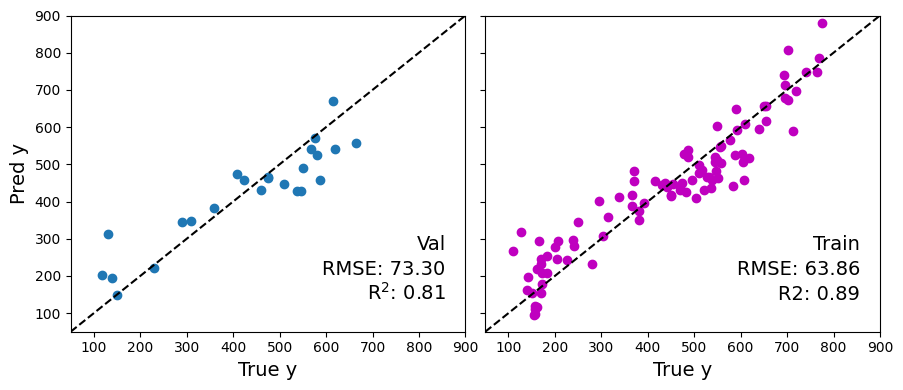

Root Mean squared error: 73.30
Coefficient of determination: 0.81


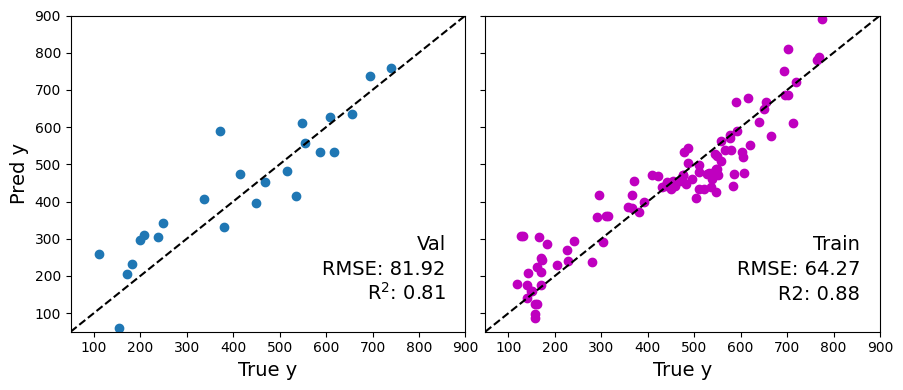

Root Mean squared error: 81.92
Coefficient of determination: 0.81


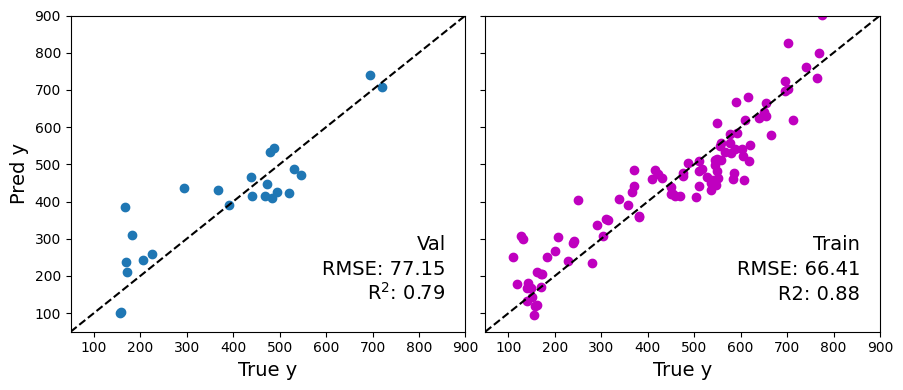

Root Mean squared error: 77.15
Coefficient of determination: 0.79


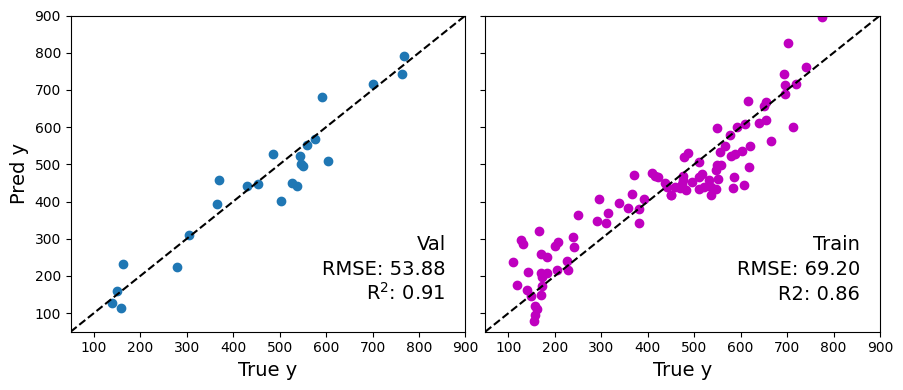

Root Mean squared error: 53.88
Coefficient of determination: 0.91


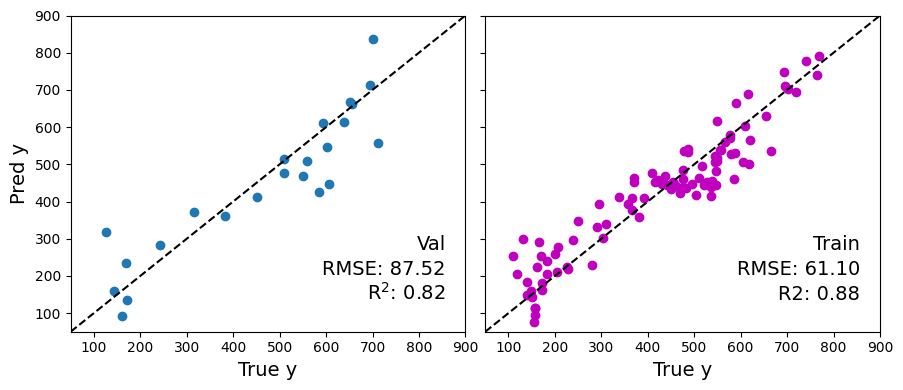

Root Mean squared error: 87.52
Coefficient of determination: 0.82


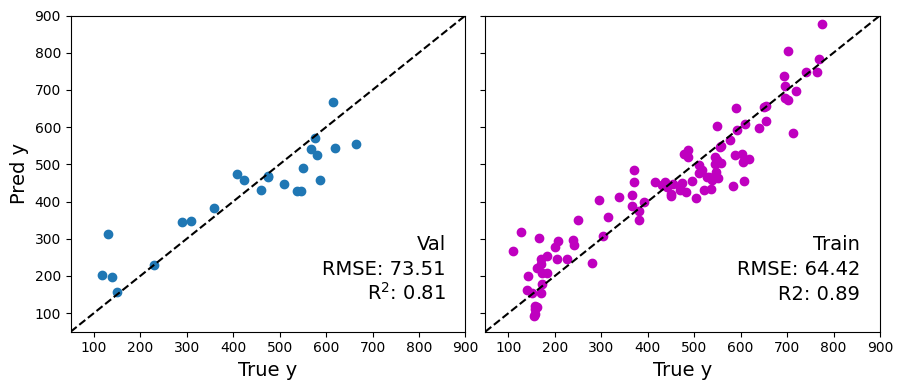

Root Mean squared error: 73.51
Coefficient of determination: 0.81


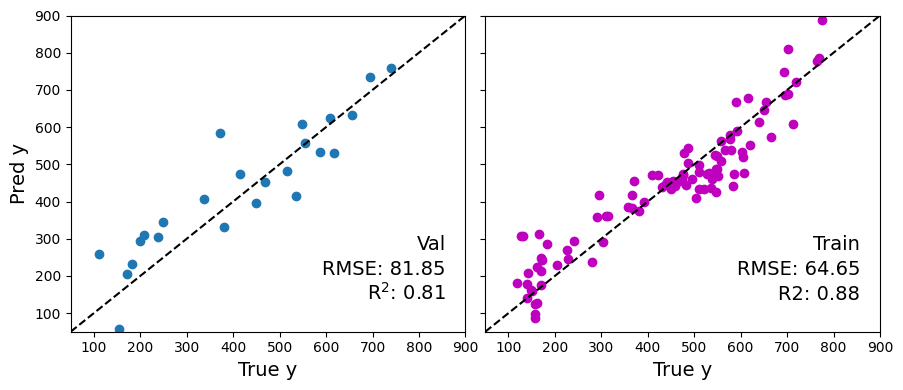

Root Mean squared error: 81.85
Coefficient of determination: 0.81


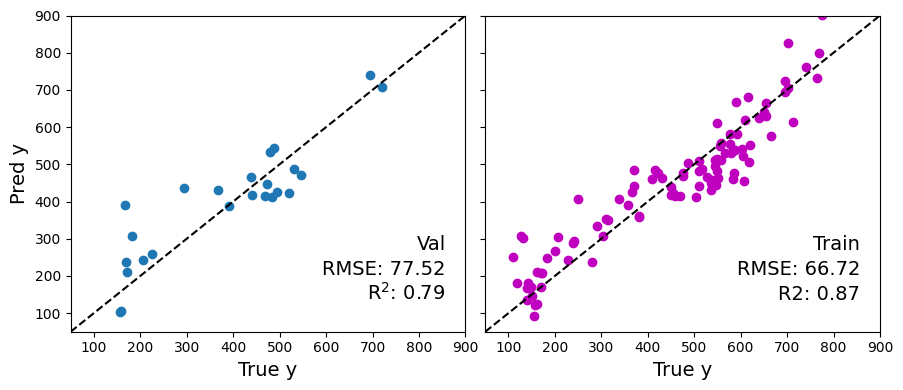

Root Mean squared error: 77.52
Coefficient of determination: 0.79


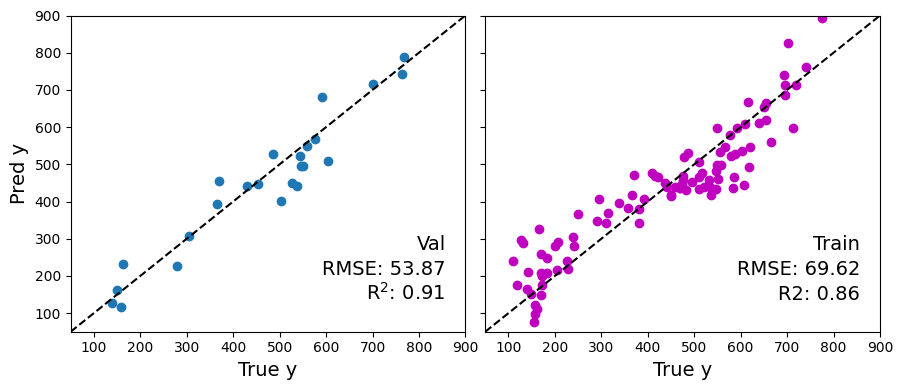

Root Mean squared error: 53.87
Coefficient of determination: 0.91


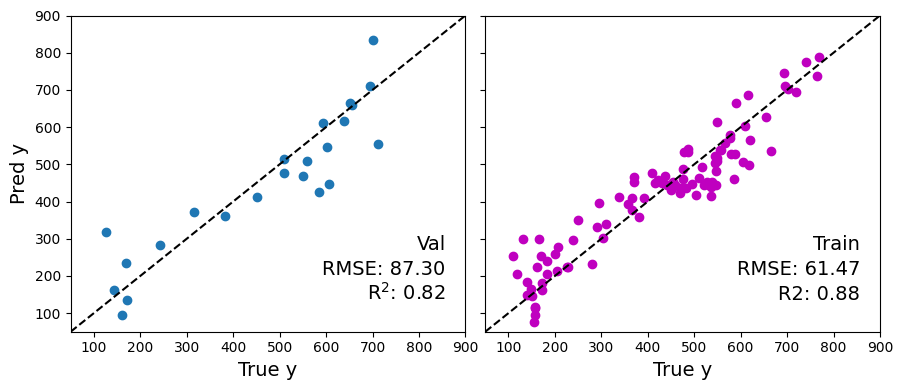

Root Mean squared error: 87.30
Coefficient of determination: 0.82


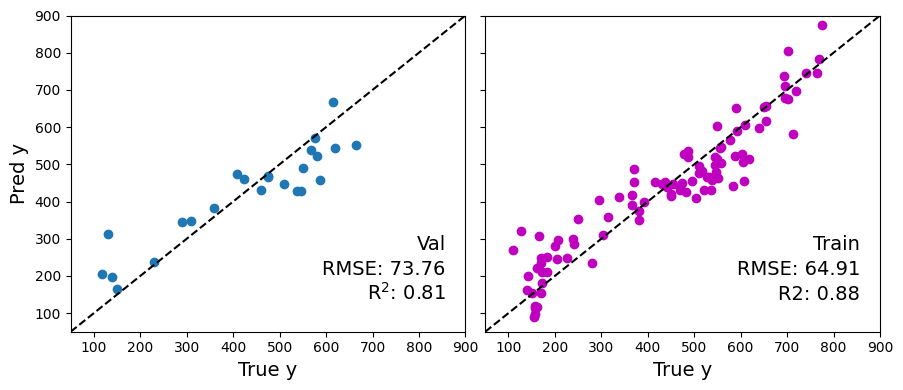

Root Mean squared error: 73.76
Coefficient of determination: 0.81


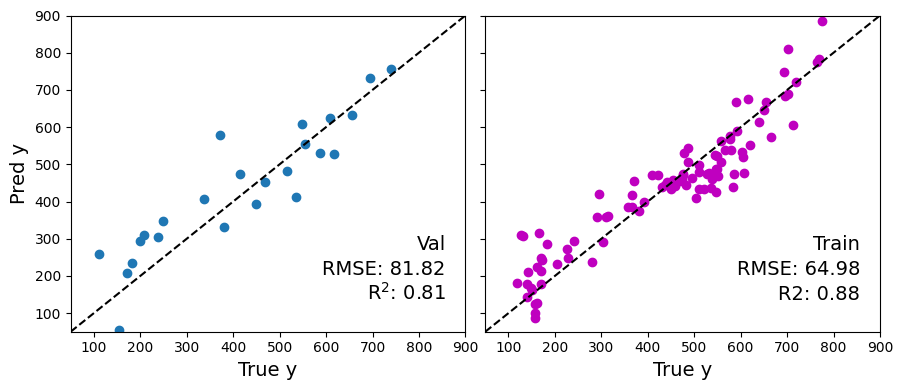

Root Mean squared error: 81.82
Coefficient of determination: 0.81


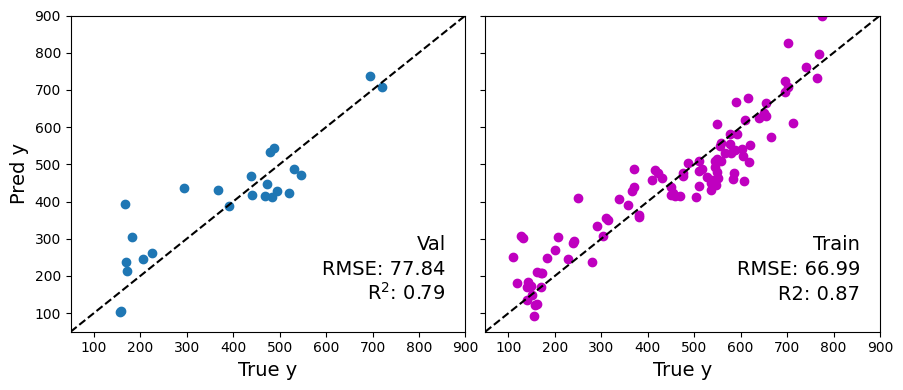

Root Mean squared error: 77.84
Coefficient of determination: 0.79


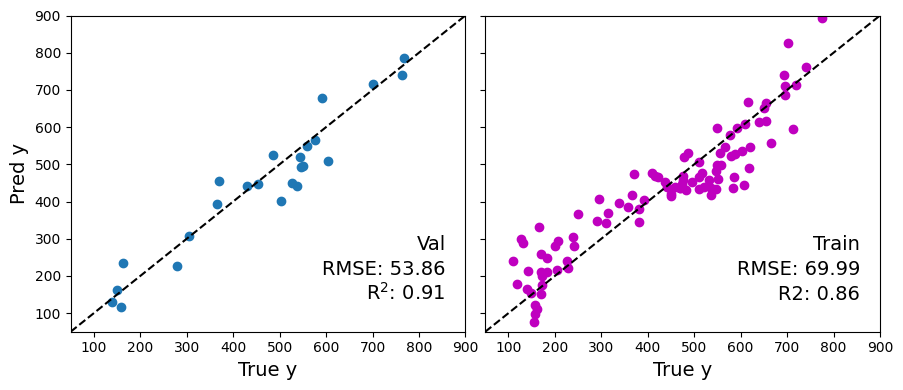

Root Mean squared error: 53.86
Coefficient of determination: 0.91


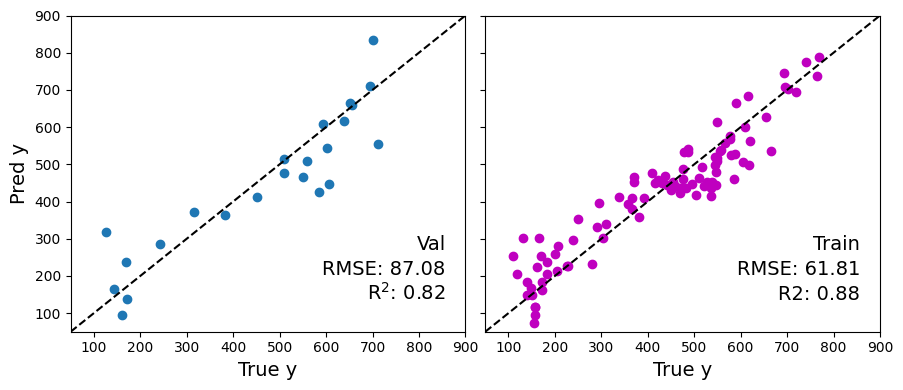

Root Mean squared error: 87.08
Coefficient of determination: 0.82


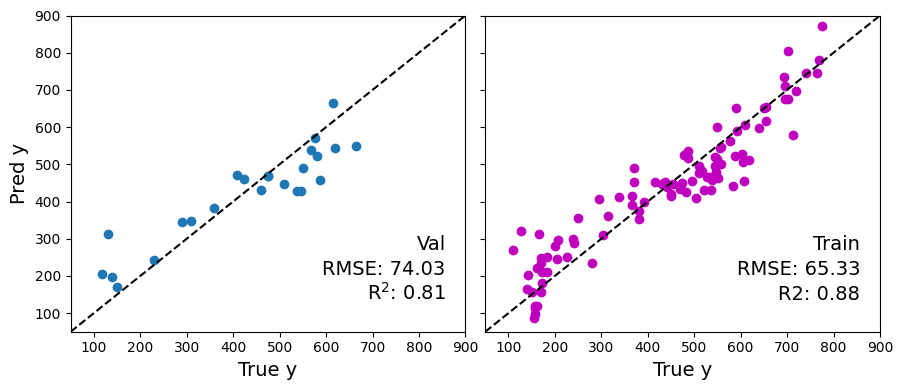

Root Mean squared error: 74.03
Coefficient of determination: 0.81


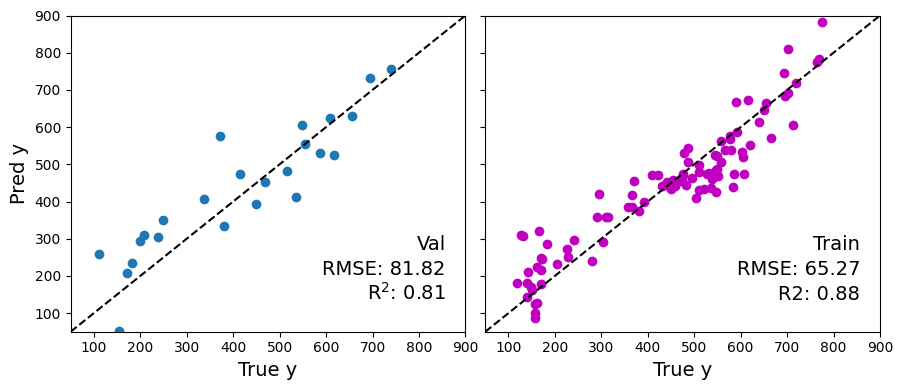

Root Mean squared error: 81.82
Coefficient of determination: 0.81


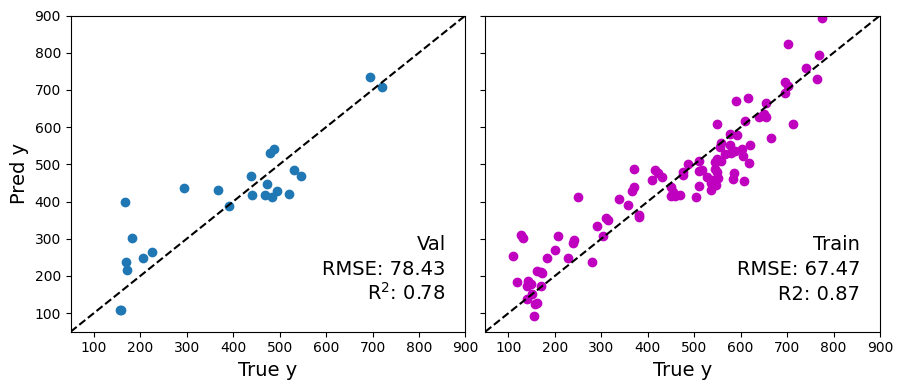

Root Mean squared error: 78.43
Coefficient of determination: 0.78


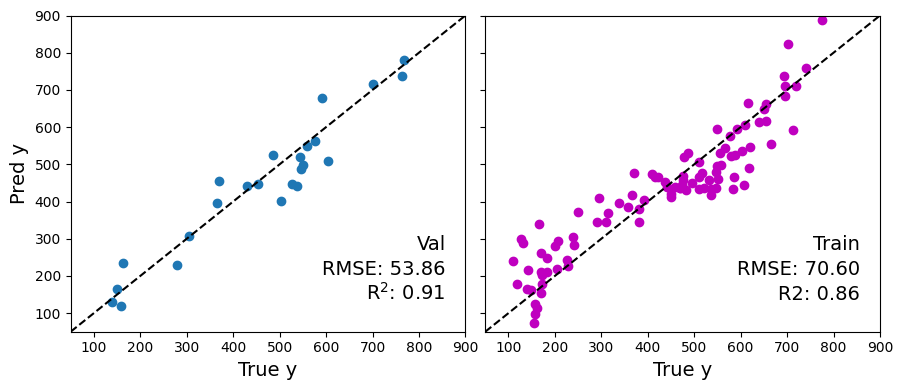

Root Mean squared error: 53.86
Coefficient of determination: 0.91


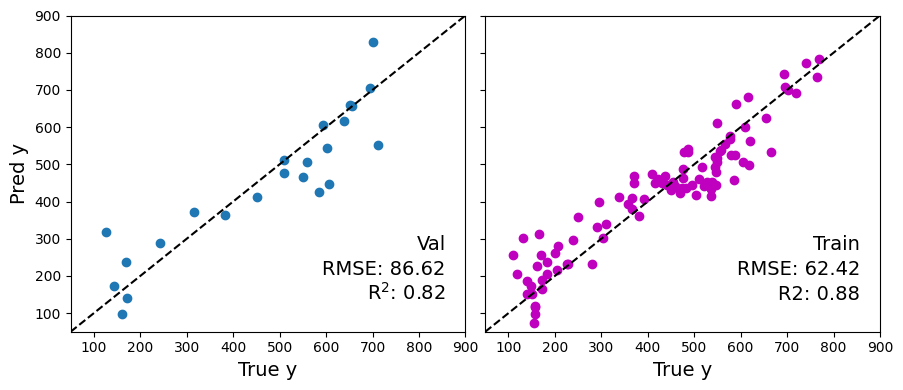

Root Mean squared error: 86.62
Coefficient of determination: 0.82


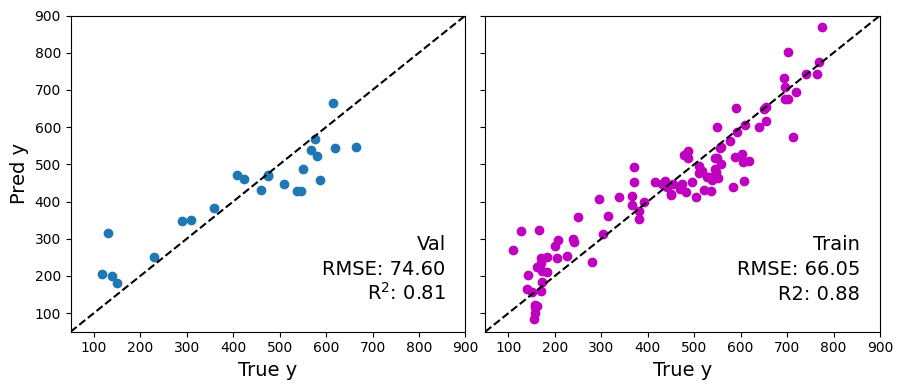

Root Mean squared error: 74.60
Coefficient of determination: 0.81


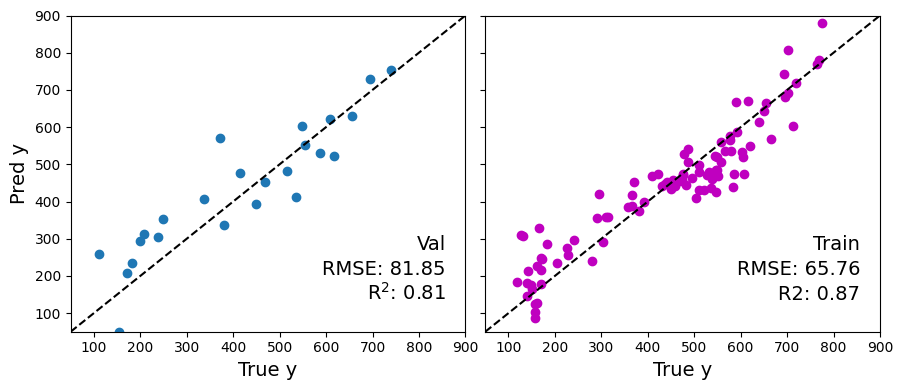

Root Mean squared error: 81.85
Coefficient of determination: 0.81


In [620]:
#c_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2, 3]

c_values = [1, 2, 3, 3.5, 4, 5, 6, 7, 8, 10]
errors_norm = []

for alp in c_values:
    pr_l2_norm = Ridge(alpha=alp)
    for idx, (train, val) in enumerate(kf.split(X)):
        _X_cv_train = X.values[train]
        _X_cv_val = X.values[val]

        X_cv_train = scaler.fit_transform(_X_cv_train)
        X_cv_val = scaler.transform(_X_cv_val)

        y_cv_train = y.values[train]
        y_cv_val = y.values[val]


        # Model fit and prediction
        model = pr_l2_norm.fit(X_cv_train,y_cv_train)
        y_pred_val = model.predict(X_cv_val)
        y_pred_train = model.predict(X_cv_train)


        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
        rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

        r2_val = r2_score(y_cv_val, y_pred_val)
        r2_train = r2_score(y_cv_train, y_pred_train)


        # Plot Parity plot
        polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

        print("Root Mean squared error: %.2f" % rmse_val)
        print("Coefficient of determination: %.2f" % r2_val) 

        error = {'c':alp,
                 'kfold': idx+1,
                 'rmse_train': rmse_train,
                 'rmse_val': rmse_val,
                 'r2_val': r2_val,
                 'r2_train': r2_train}

        errors_norm.append(error)

errors_norm = pd.DataFrame(errors_norm)   

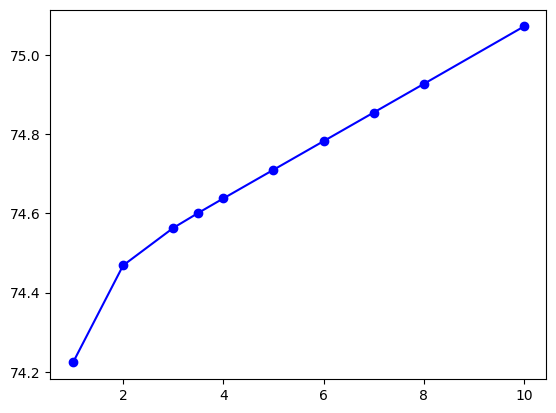

In [621]:
plt.plot(c_values, errors_norm.groupby('c').mean()['rmse_val'], '-bo')

In [622]:
c_grp_data = errors_norm.groupby('c').mean()
norm_c_opt = c_grp_data.index[c_grp_data['rmse_val'].argmin()]
errors_pr_norm = errors_norm.loc[errors_norm['c'] == norm_c_opt]
errors_pr_norm.mean()

c              1.000000
kfold          3.000000
rmse_train    60.781537
rmse_val      74.223688
r2_val         0.832462
r2_train       0.893267
dtype: float64

In [623]:
errors_l2_c_opt.mean()

kfold          3.000000
rmse_train    59.588242
rmse_val      72.634987
r2_val         0.840528
r2_train       0.897450
dtype: float64

### Question
1. Why normalization is done only on the train set during cross-validation?
2. Is the optimized coefficient value same for the pristine and the normalized data? Why or why not?

### Recursive feature elimination

In [624]:
pr_l2_copt_rfe = Ridge(alpha=c_opt)
selector = RFECV(pr_l2_copt_rfe, step=1, cv=5, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)
sel_features = Xcols[selector.support_]

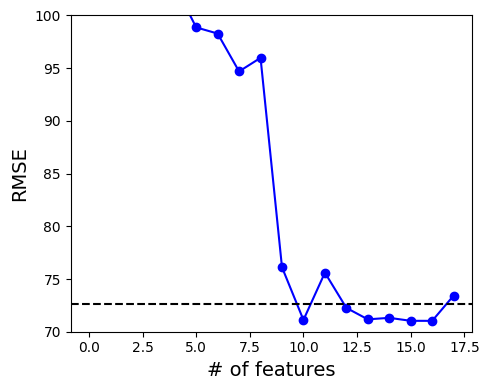

In [625]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(np.sqrt(selector.cv_results_['mean_test_score']*-1), '-bo')
ax1.axhline(errors_l2_c_opt.mean()['rmse_val'], linestyle='--', color='k')
ax1.set_ylim(70,100)
ax1.set_xlabel('# of features', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=14)
plt.tight_layout()

In [626]:
print("Initial number of features", selector.n_features_in_)
print("Selected number of features", selector.n_features_)

Initial number of features 18
Selected number of features 17


In [627]:
rmse_rfe = np.sqrt((selector.cv_results_['mean_test_score']*-1).min())
print("Root Mean square error with RFE (eV^2): ", rmse_rfe)

Root Mean square error with RFE (eV^2):  71.03210218455169


In [628]:
sel_features

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni', 'n.1', 'n.2', 'n.3',
       'n.4', 'n.5', 'n.6', 'n.7', 'n.8', 'n.9', 'n.10', 'n.11'],
      dtype='object')

In [629]:
X = new_data[sel_features]

In [630]:
c_values = [0.0001, 0.0005, 0.00065, 0.0008, 0.001, 0.0012, 0.0014, 0.002, 0.01, 0.05, 0.1, 1, 2]
hyper_params = {'alpha':c_values}

pr_rfe_ridge = Ridge()
clf = GridSearchCV(pr_rfe_ridge, hyper_params, cv=5, scoring='neg_mean_squared_error')

_ = clf.fit(X,y)

In [631]:
rmse_list = np.sqrt(clf.cv_results_['mean_test_score']*-1)
rmse_list

array([ 71.03210218,  72.61826516,  72.93527759,  73.1826779 ,
        73.45172179,  73.68122858,  73.88786831,  74.4385077 ,
        78.9929374 ,  83.9944673 ,  85.43339846, 110.25749228,
       130.01612739])

Text(0, 0.5, 'RMSE')

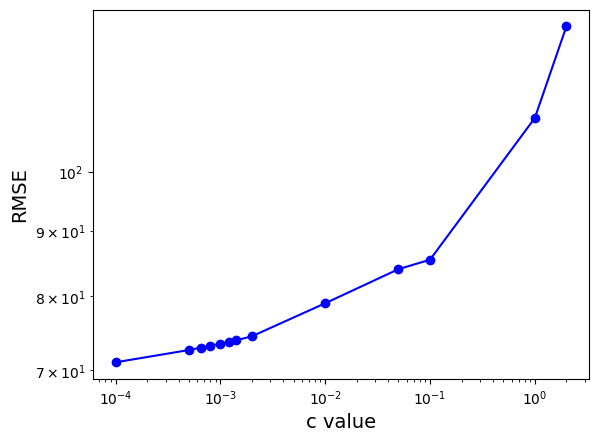

In [632]:
plt.plot(c_values, rmse_list, '-bo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('c value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

In [633]:
min_idx = np.argmin(rmse_list)

c_values[min_idx], rmse_list[min_idx]

(0.0001, 71.03210218455169)

In [634]:
c_opt_rfe = c_values[min_idx]

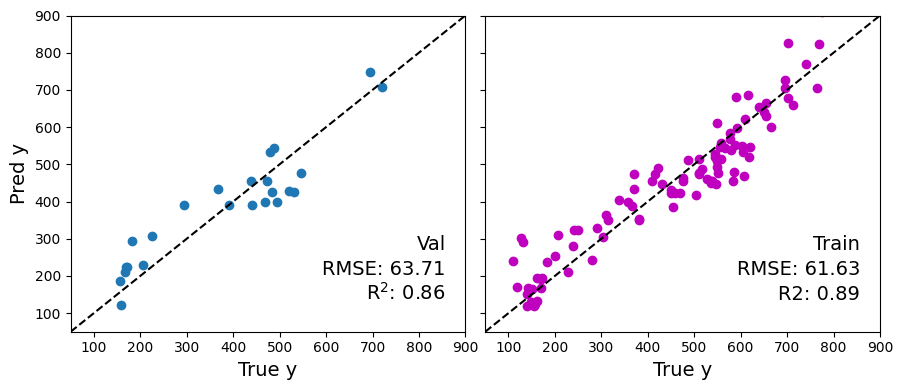

Root Mean squared error: 63.71
Coefficient of determination: 0.86


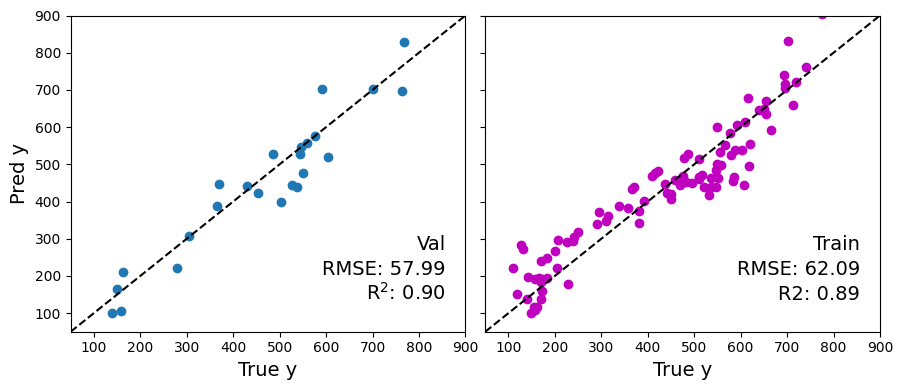

Root Mean squared error: 57.99
Coefficient of determination: 0.90


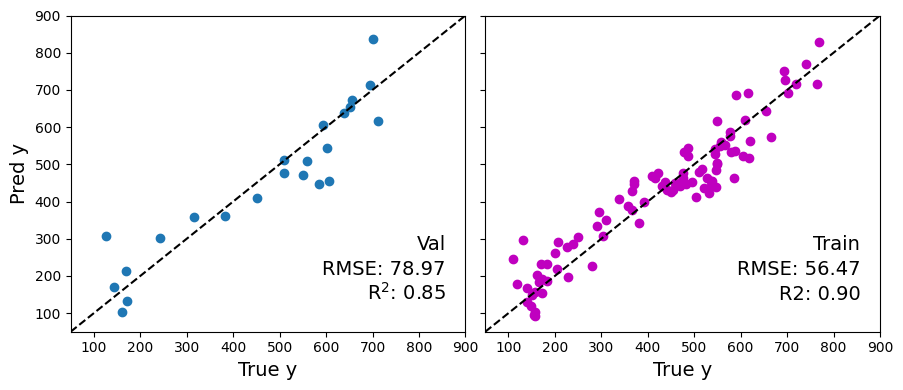

Root Mean squared error: 78.97
Coefficient of determination: 0.85


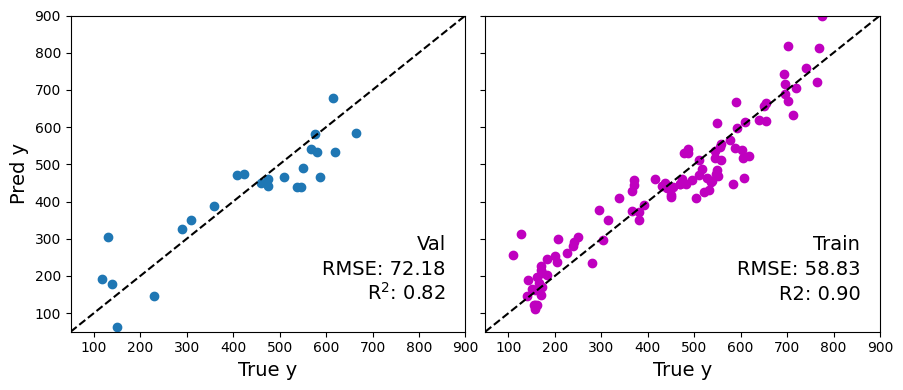

Root Mean squared error: 72.18
Coefficient of determination: 0.82


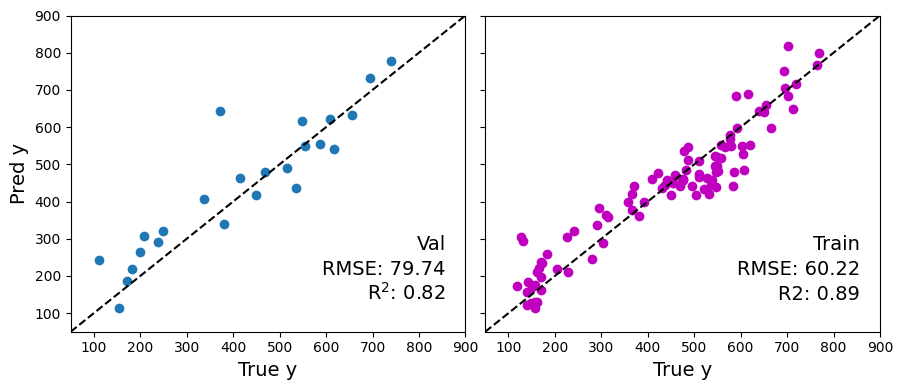

Root Mean squared error: 79.74
Coefficient of determination: 0.82


In [635]:
pr_rfe_c_opt = Ridge(alpha=c_opt_rfe)

errors_rfe_c_opt = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = pr_rfe_c_opt.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_rfe_c_opt.append(error)
errors_rfe_c_opt = pd.DataFrame(errors_rfe_c_opt)

In [636]:
errors_rfe_c_opt.mean()

kfold          3.000000
rmse_train    59.847436
rmse_val      70.519867
r2_val         0.849713
r2_train       0.896552
dtype: float64

In [637]:
errors_l2_c_opt.mean()

kfold          3.000000
rmse_train    59.588242
rmse_val      72.634987
r2_val         0.840528
r2_train       0.897450
dtype: float64

### Plot All errors

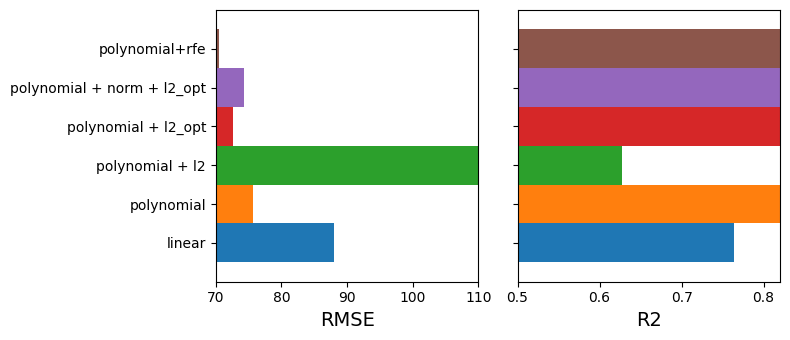

In [638]:
width = 0.1
labels = ['linear','polynomial','polynomial + l2','polynomial + l2_opt','polynomial + norm + l2_opt', 'polynomial+rfe']
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)
    
for idx,e in enumerate([errors, errors_pr, errors_pr_l2, errors_l2_c_opt, errors_pr_norm, errors_rfe_c_opt]):
    mse = e.mean()['rmse_val']
    r2 = e.mean()['r2_val']
    
    ax1.barh(0 + width*(idx-1), mse, height=width, label=labels[idx], align='center')
    ax2.barh(0 + width*(idx-1), r2, height=width, label=labels[idx], align='center')    
    
ax1.set_xlabel('RMSE', fontsize=14)
ax2.set_xlabel('R2', fontsize=14)    

ax1.set_yticks([-0.1,0,0.1,0.2, 0.3, 0.4])
ax1.set_yticklabels(labels)

ax1.set_ylim(-0.2,0.5)
ax1.set_xlim(70,110)
ax2.set_xlim(0.5,0.82)

plt.tight_layout()
plt.show()

1. Why polynomial regression model has better accuracy than that of linear regression model?
- Since polynomial regression model involves non linear higher order terms, it can fit the data more precisely with less errors.

2. Regularization seems to decrease model accuracy. Can you spot someway of improving performance of the regularized model?
 - Hyperparameter optimisation is a method of introducing a parameter lambda and changing the values to find the optimised value for lowest error
 - Feature selection/removal process is to select the features that are the most contributing to the fit i.e, removal of ouliers. example: recursive feature elimination

3. Try making new polynomial type features to improve polynomial regression model accuracy. Explain why addition of new features could improve model performance. 
- Including new features will add more higher order terms to the model which could fit the model more precisely and flexibly with much lower errors.


- The error associated with features n.1 to n.5 is given by
- rmse_val    81.335727
- r2_val       0.797802
- Here new features from n.6 to n.11 has been included and then the error is calculated.
- From this, the error has been decreased.

In [639]:
errors_pr[['rmse_val','r2_val']].mean()

rmse_val    75.637596
r2_val       0.827093
dtype: float64

1. Why normalization is done only on the train set during cross-validation?
- If the normalization is done for the whole set, the parameters found would be representative of the whole set. Therefore the errors will be more once the model is used for unseen data. Therefore it is done only for training set and then with test set during model testing then employed.

2. Is the optimized coefficient value same for the pristine and the normalized data? Why or why not?
- No the cofficient value are not the same but normalised coefficient can be rescaled to original conditions using the parameters.
- Because the range of values will be different for normalised data which is different from the original data. 